In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
import torchinfo
from pathlib import Path

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [23]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=6,div=1400000,verbose=False):
        
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.div = div
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        self.aa_freqs = {} #frequencies of each symbol in the sequence family
        self.p_aa_freqs = {} #frequencies of each symbol in each sequence of a family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    aa_freq = torch.zeros(20)
                    p_aa_freq = torch.zeros(0)
                    
                    #parsing the file
                    line = f.readline()[:-1]
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            if not first_prot:
                                p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                            prot_aa_freq = torch.zeros(1,20)
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                            for aa in line:
                                aa_id = ALPHABET.get(aa,21)
                                if aa_id < 20:
                                    aa_freq[aa_id] += 1
                                    prot_aa_freq[0][aa_id] += 1

                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()[:-1]
                    
                    p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                    aa_freq = F.normalize(aa_freq,dim=0,p=1)
                    p_aa_freq = F.normalize(p_aa_freq,dim=1,p=1)

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if n>1: #if this is false, we can't find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    self.aa_freqs[count] = aa_freq
                    self.p_aa_freqs[count] = p_aa_freq
                    count += 1
                    
                    if verbose and (count % 100 ==0) : print(f"seen = {count}")
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto'): 
        #for each sample:
        #sample i, j st i != j the two sequences to compare
        #sample k the sequence position of the prediction
        #compute the file positions of the 25 + 1 AA
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        pfreqs = []
        local_pfreqs = []
        
        lengths = []
        
        pos = []
        
        
        precomputed_pos = []
        for i in range(-self.cont_size,self.cont_size+1):
            precomputed_pos.append(i)
        for i in range(-self.cont_size,0):
            precomputed_pos.append(i)
        for i in range(1,self.cont_size+1):
            precomputed_pos.append(i)
        
        precomputed_pos = torch.tensor(precomputed_pos).float()
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        if type(sample_size) != int:
            coef = round((n**2 * l)/self.div) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1


        for _ in range(sample_size):
            i,j = self.sample(n,s=2)

            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            seq_i = ''
            seq_j = ''
            
            PID_ij = 0
            
            l_ij = 0
            for offset in range(sequence_line_count-1):
                line_i = linecache.getline(data_path, (start_i + offset))[:-1]
                line_j = linecache.getline(data_path, (start_j + offset))[:-1]
                for aa_i, aa_j in zip(line_i,line_j):
                    if aa_i == aa_j:
                        if aa_i != '-':
                            PID_ij += 1
                            seq_i += aa_i
                            seq_j += aa_j        
                    else:
                        seq_i += aa_i
                        seq_j += aa_j
                    
                    if aa_i != '-' and aa_j != '-':
                        l_ij += 1
            
            try:
                PID_ij = PID_ij/l_ij
            except:
                PID_ij = 0
            
            align_l = len(seq_i)
            possible_k = []
            for k,(a_i,a_j) in enumerate(zip(seq_i,seq_j)):   
                if ALPHABET.get(a_i,21) < 20 and ALPHABET.get(a_j,21) < 20:
                    possible_k.append(k)
                    
            try:   
                k = np.random.choice(possible_k)
            except:
                continue
                
            lengths.append(align_l)
            pos_ij = (k + precomputed_pos)
            pos.append(pos_ij)
            
            window_i = ''
            window_j = ''
            
            for w in range(k-self.cont_size,k+self.cont_size+1):
                if w < 0 or w >= align_l: #case of the edges
                    window_i += 'Z'
                    window_j += 'Z'
                else:
                    window_i += seq_i[w]
                    window_j += seq_j[w]
        
            y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
            X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       
            
            X.append(X_i)
            y.append(y_j)
            PIDs.append(PID_ij)
            local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20) \
                         + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20)
            
            loc_comp = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20) \
                         + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20)
            try:
                tmp = local_PID_ij/loc_comp
            except:
                tmp = 0
                
            local_PIDs.append(tmp)
            pfreqs.append(self.aa_freqs[idx])
            p_i_freqs = self.p_aa_freqs[idx][i]
            p_j_freqs = self.p_aa_freqs[idx][j]
            
            local_pfreqs.append(torch.stack((p_i_freqs,p_j_freqs)))
            
            assert y_j < 20
            assert X_i[self.cont_size] < 20
            
        linecache.clearcache()   
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        if len(pos) == 0:
            pos = torch.tensor(pos)
        else:
            pos = torch.stack(pos)
        pfreqs = torch.stack(pfreqs)
        local_pfreqs = torch.stack(local_pfreqs)
        X = X.float()
        y = torch.tensor(y)
        PIDs = torch.tensor(PIDs)
        local_PIDs = torch.tensor(local_PIDs)
        lengths = torch.tensor(lengths)
        out = X,y.long(),PIDs,local_PIDs,pfreqs,local_pfreqs,pos,lengths
        return out

    

In [24]:
"""
train_dataset = MyDataset(r"data/train_data",cont_size = 6)
test_dataset = MyDataset(r"data/test_data",cont_size = 6,div=700000)
val_dataset = MyDataset(r"data/val_data",cont_size = 6,div=700000)

fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(train_dataset,fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(test_dataset,fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(val_dataset,fp)
"""

'\ntrain_dataset = MyDataset(r"data/train_data",cont_size = 6)\ntest_dataset = MyDataset(r"data/test_data",cont_size = 6,div=700000)\nval_dataset = MyDataset(r"data/val_data",cont_size = 6,div=700000)\n\nfname = \'data/train_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(train_dataset,fp)\n    \nfname = \'data/test_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(test_dataset,fp)\n    \nfname = \'data/val_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(val_dataset,fp)\n'

In [25]:
fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    train_dataset = torch.load(fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    test_dataset = torch.load(fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    val_dataset = torch.load(fp)
    
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

13219
2838
2826


In [26]:
def my_collate(batch):
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    pfreqs = torch.cat([item[4] for item in batch],dim=0)
    lpfreqs = torch.cat([item[5] for item in batch],dim=0)
    pos = torch.cat([item[6] for item in batch],dim=0)
    length = torch.cat([item[7] for item in batch],dim=0)
    return data, target, PID, lPID,pfreqs,lpfreqs, pos, length

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

In [28]:
class AttBlock(nn.Module):
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [29]:
class FeedFoward(nn.Module):
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [30]:
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [31]:
class Block(nn.Module):
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x + self.drop_path(self.att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        return out

In [32]:
class Classifier_Head(nn.Module):
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=0.2))
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.reshape((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [37]:
class AttNet(nn.Module):
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,input_dim=21,out_size=20,seq_len=30,clf_dims=[256,64],cont_size=6):
        super().__init__()
        
        blocks = []
        for n_h, h_d,w,d in zip(num_heads,head_dims,wide_factors,drops):
            blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
        self.feature_extractor = nn.Sequential(*blocks)
        self.in_features = in_features
        self.input_dim = input_dim
        self.clf = Classifier_Head(in_features,clf_dims,out_size=out_size,seq_len=seq_len)
        
        self.cont_size=cont_size
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.log(torch.load(fp)))
            
        pid_layers = [nn.Linear(1,in_features),nn.Sigmoid()]
        self.pid_l = nn.Sequential(*pid_layers)
    
    def to_input(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        seq1 = x[:,:2*self.cont_size+1]
        y_freq = F.pad(F.softmax(self.F[X_idx],dim=1).unsqueeze(1), pad=(0, 1), mode='constant', value=0) 
        seq2 = torch.cat((x[:,2*self.cont_size+1:3*self.cont_size+1],y_freq,x[:,3*self.cont_size+1:]),dim=1)
        aa_pos = pos[:,:2*self.cont_size+1]/length.unsqueeze(1)
        aa_pos = aa_pos.unsqueeze(2)
        pos_dim = (self.in_features-self.input_dim-1)//2
        
        for i in range(pos_dim): #positionnal_encoding
            p = torch.cos(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            ip = torch.sin(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            aa_pos = torch.cat([aa_pos,p,ip],dim=2)

        seq1 = torch.cat([seq1,aa_pos],dim=2)
        seq2 = torch.cat([seq2,aa_pos],dim=2)
        X = torch.cat([seq1,seq2],dim=1)
        
        pad = (0,self.in_features-self.input_dim+1)
        pf = F.pad(pfreqs.unsqueeze(1),pad =pad, mode='constant', value=0)
        pid = self.pid_l(PID.unsqueeze(1)).unsqueeze(1)
        lpf = F.pad(lpfreqs,pad=pad, mode='constant', value=0)

        X_input = torch.cat([X,pf,lpf,pid],dim=1)
        
        return X_input
    
    def forward(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_input = self.to_input(x,PID,pfreqs,lpfreqs,pos,length)
        features = self.feature_extractor(X_input)
        out = self.clf(features)
        return out

In [38]:
class State:
    def __init__(self,model,optim,scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.epoch = 0

In [63]:
def eval_model(fname,train,test,val,N=10):
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())

        score_train = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in test:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_test = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos, length in val:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                lPID = lPID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_val = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [64]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",fnameb=None,state=None,last_epoch_sched=float('inf'),use_mut=True):
    
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    if fnameb is None:
        fnameb = fname[:-4] + '_best' +fname[-4:]
        
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if state is None:
            model = AttNet(22,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
            model = model.to(device)
            optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
            state = State(model,optim,scheduler)
    
    
    Loss = nn.CrossEntropyLoss(reduction='sum')
    LossMut = nn.BCELoss(reduction='sum')
    EvalLoss = nn.MSELoss(reduction='mean')
    
    #for logs
    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train_loader:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            pos = pos.to(device)
            pfreqs = pfreqs.to(device)
            lpfreqs = lpfreqs.to(device)
            length = length.to(device)
            
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
            

            if use_mut:
                X_idx = torch.argmax(X[:,6],dim=1)
                y_true = (X_idx == y).float().unsqueeze(1)  #0 if a mutation happens else 1 
                y_pred = F.softmax(y_hat,dim=1)
                y_pred = y_pred.gather(1,X_idx.view(-1,1)) #the Xth component of y_hat should be predicting ^
                l = (Loss(y_hat,y) + LossMut(y_pred,y_true))/311
            else:
                l = Loss(y_hat,y)/311
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        if epoch < last_epoch_sched:
            state.scheduler.step()
        
        savepath = Path(fname)
        with savepath.open("wb") as fp:
            torch.save(state,fp)
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
            score = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            savepath = Path(fnameb)
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, val_loss = {Eval_Loss[-1]}") 


        
    return List_Loss,Eval_Loss,state

In [65]:
def get_params(input_size,N,head,head_dim,wide_factor,drop_prob):
    return input_size, [head for _ in range(N)], [head_dim for _ in range(N)], [wide_factor for _ in range(N)], [drop_prob for _ in range(N)], 

In [66]:
params = get_params(32,4,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
torchinfo.summary(model,[(1,25,21),(1,),(1,20),(1,2,20),(1,25),(1,)])

Layer (type:depth-idx)                        Output Shape              Param #
AttNet                                        [1, 20]                   400
├─Sequential: 1-1                             [1, 32]                   --
│    └─Linear: 2-1                            [1, 32]                   64
│    └─Sigmoid: 2-2                           [1, 32]                   --
├─Sequential: 1-2                             [1, 30, 32]               --
│    └─Block: 2-3                             [1, 30, 32]               --
│    │    └─AttBlock: 3-1                     [1, 30, 32]               295,968
│    │    └─DropPath: 3-2                     [1, 30, 32]               --
│    │    └─LayerNorm: 3-3                    [1, 30, 32]               64
│    │    └─FeedFoward: 3-4                   [1, 30, 32]               8,352
│    │    └─DropPath: 3-5                     [1, 30, 32]               --
│    │    └─LayerNorm: 3-6                    [1, 30, 32]               64
│    └─Bloc

In [72]:
params = get_params(32,4,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/stateATT_4L_fixed.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.7820186614990234, val_loss = 0.8786128163337708
epoch n°1 : train_loss = 2.496732711791992, val_loss = 0.8379143476486206
epoch n°2 : train_loss = 2.396580696105957, val_loss = 0.8233270645141602
epoch n°3 : train_loss = 2.3632419109344482, val_loss = 0.8242983222007751
epoch n°4 : train_loss = 2.341736316680908, val_loss = 0.8151569366455078
epoch n°5 : train_loss = 2.330084800720215, val_loss = 0.8113887906074524
epoch n°6 : train_loss = 2.3223018646240234, val_loss = 0.8084423542022705
epoch n°7 : train_loss = 2.3109476566314697, val_loss = 0.8103057146072388
epoch n°8 : train_loss = 2.3055741786956787, val_loss = 0.8092596530914307
epoch n°9 : train_loss = 2.294175386428833, val_loss = 0.8076428771018982
epoch n°10 : train_loss = 2.294893264770508, val_loss = 0.8058606386184692
epoch n°11 : train_loss = 2.2987349033355713, val_loss = 0.8114710450172424
epoch n°12 : train_loss = 2.287438154220581, val_loss = 0.8090648651123047
epoch n°13 : train_loss = 2.2

epoch n°109 : train_loss = 2.194643020629883, val_loss = 0.7960415482521057
epoch n°110 : train_loss = 2.2085750102996826, val_loss = 0.7987204790115356
epoch n°111 : train_loss = 2.1956968307495117, val_loss = 0.795861005783081
epoch n°112 : train_loss = 2.2203705310821533, val_loss = 0.7983351945877075
epoch n°113 : train_loss = 2.2149548530578613, val_loss = 0.8011788129806519
epoch n°114 : train_loss = 2.2284748554229736, val_loss = 0.8026575446128845
epoch n°115 : train_loss = 2.2205591201782227, val_loss = 0.8040472269058228
epoch n°116 : train_loss = 2.224886178970337, val_loss = 0.799980103969574
epoch n°117 : train_loss = 2.2168514728546143, val_loss = 0.8045084476470947
epoch n°118 : train_loss = 2.215970039367676, val_loss = 0.800125002861023
epoch n°119 : train_loss = 2.2299087047576904, val_loss = 0.7986940741539001
epoch n°120 : train_loss = 2.2166528701782227, val_loss = 0.7978545427322388
epoch n°121 : train_loss = 2.2222299575805664, val_loss = 0.8009495735168457
epoch

epoch n°217 : train_loss = 2.164964437484741, val_loss = 0.7964461445808411
epoch n°218 : train_loss = 2.1685073375701904, val_loss = 0.7924831509590149
epoch n°219 : train_loss = 2.177841901779175, val_loss = 0.7966830134391785
epoch n°220 : train_loss = 2.1617815494537354, val_loss = 0.7964267730712891
epoch n°221 : train_loss = 2.167971611022949, val_loss = 0.795137882232666
epoch n°222 : train_loss = 2.1667776107788086, val_loss = 0.7941673398017883
epoch n°223 : train_loss = 2.1639537811279297, val_loss = 0.7903527021408081
epoch n°224 : train_loss = 2.167325019836426, val_loss = 0.7972897887229919
epoch n°225 : train_loss = 2.1676554679870605, val_loss = 0.795190155506134
epoch n°226 : train_loss = 2.1697821617126465, val_loss = 0.7974259257316589
epoch n°227 : train_loss = 2.1700024604797363, val_loss = 0.7925180196762085
epoch n°228 : train_loss = 2.1640031337738037, val_loss = 0.7999800443649292
epoch n°229 : train_loss = 2.1716418266296387, val_loss = 0.7943512201309204
epoch

epoch n°325 : train_loss = 2.170844078063965, val_loss = 0.7925413250923157
epoch n°326 : train_loss = 2.1630187034606934, val_loss = 0.7963082790374756
epoch n°327 : train_loss = 2.1650102138519287, val_loss = 0.7952379584312439
epoch n°328 : train_loss = 2.1694140434265137, val_loss = 0.7999599575996399
epoch n°329 : train_loss = 2.162374496459961, val_loss = 0.7957209348678589
epoch n°330 : train_loss = 2.170335292816162, val_loss = 0.7991862893104553
epoch n°331 : train_loss = 2.1643879413604736, val_loss = 0.7967243790626526
epoch n°332 : train_loss = 2.163628578186035, val_loss = 0.8007946610450745
epoch n°333 : train_loss = 2.1668198108673096, val_loss = 0.7971087694168091
epoch n°334 : train_loss = 2.1703054904937744, val_loss = 0.7969145178794861
epoch n°335 : train_loss = 2.1613430976867676, val_loss = 0.801114559173584
epoch n°336 : train_loss = 2.155878782272339, val_loss = 0.7956725358963013
epoch n°337 : train_loss = 2.1701431274414062, val_loss = 0.7965765595436096
epoch

epoch n°433 : train_loss = 2.134564161300659, val_loss = 0.795060396194458
epoch n°434 : train_loss = 2.1393375396728516, val_loss = 0.794508695602417
epoch n°435 : train_loss = 2.1227221488952637, val_loss = 0.7936189770698547
epoch n°436 : train_loss = 2.125113010406494, val_loss = 0.798017680644989
epoch n°437 : train_loss = 2.1252057552337646, val_loss = 0.7974850535392761
epoch n°438 : train_loss = 2.129065990447998, val_loss = 0.7927441000938416
epoch n°439 : train_loss = 2.131645441055298, val_loss = 0.7943243980407715
epoch n°440 : train_loss = 2.1307482719421387, val_loss = 0.7909774780273438
epoch n°441 : train_loss = 2.1272504329681396, val_loss = 0.7913808822631836
epoch n°442 : train_loss = 2.1291346549987793, val_loss = 0.794945478439331
epoch n°443 : train_loss = 2.1245803833007812, val_loss = 0.7950128316879272
epoch n°444 : train_loss = 2.134723424911499, val_loss = 0.795994222164154
epoch n°445 : train_loss = 2.1215362548828125, val_loss = 0.7931074500083923
epoch n°4

epoch n°541 : train_loss = 2.1503310203552246, val_loss = 0.7957137823104858
epoch n°542 : train_loss = 2.1441502571105957, val_loss = 0.7969171404838562
epoch n°543 : train_loss = 2.1451189517974854, val_loss = 0.7967893481254578
epoch n°544 : train_loss = 2.1446499824523926, val_loss = 0.8011394739151001
epoch n°545 : train_loss = 2.145958423614502, val_loss = 0.7959136962890625
epoch n°546 : train_loss = 2.1519837379455566, val_loss = 0.7980996966362
epoch n°547 : train_loss = 2.148897409439087, val_loss = 0.794563889503479
epoch n°548 : train_loss = 2.16215443611145, val_loss = 0.8000584244728088
epoch n°549 : train_loss = 2.1601579189300537, val_loss = 0.7988405227661133
epoch n°550 : train_loss = 2.151627779006958, val_loss = 0.8016908168792725
epoch n°551 : train_loss = 2.1486260890960693, val_loss = 0.7973856329917908
epoch n°552 : train_loss = 2.145580768585205, val_loss = 0.7984769940376282
epoch n°553 : train_loss = 2.150256395339966, val_loss = 0.7993171215057373
epoch n°55

epoch n°649 : train_loss = 2.1303791999816895, val_loss = 0.8002824187278748
epoch n°650 : train_loss = 2.1319453716278076, val_loss = 0.7975820899009705
epoch n°651 : train_loss = 2.132533550262451, val_loss = 0.7994584441184998
epoch n°652 : train_loss = 2.130791664123535, val_loss = 0.7956908345222473
epoch n°653 : train_loss = 2.1364810466766357, val_loss = 0.7974616289138794
epoch n°654 : train_loss = 2.1301305294036865, val_loss = 0.7976738810539246
epoch n°655 : train_loss = 2.126800537109375, val_loss = 0.7918621301651001
epoch n°656 : train_loss = 2.1201705932617188, val_loss = 0.7955260276794434
epoch n°657 : train_loss = 2.1267447471618652, val_loss = 0.7986381649971008
epoch n°658 : train_loss = 2.1321308612823486, val_loss = 0.795946478843689
epoch n°659 : train_loss = 2.1261467933654785, val_loss = 0.7923848032951355
epoch n°660 : train_loss = 2.125624418258667, val_loss = 0.7985841035842896
epoch n°661 : train_loss = 2.132521867752075, val_loss = 0.7926510572433472
epoch

epoch n°757 : train_loss = 2.112431526184082, val_loss = 0.7959250211715698
epoch n°758 : train_loss = 2.1150624752044678, val_loss = 0.7949783802032471
epoch n°759 : train_loss = 2.106018304824829, val_loss = 0.7940213680267334
epoch n°760 : train_loss = 2.1020054817199707, val_loss = 0.7913523316383362
epoch n°761 : train_loss = 2.1078286170959473, val_loss = 0.7940971851348877
epoch n°762 : train_loss = 2.1164636611938477, val_loss = 0.795708954334259
epoch n°763 : train_loss = 2.0963404178619385, val_loss = 0.7925156950950623
epoch n°764 : train_loss = 2.0967540740966797, val_loss = 0.7976400852203369
epoch n°765 : train_loss = 2.1064279079437256, val_loss = 0.7906830310821533
epoch n°766 : train_loss = 2.1014325618743896, val_loss = 0.7972185611724854
epoch n°767 : train_loss = 2.108130931854248, val_loss = 0.790743887424469
epoch n°768 : train_loss = 2.1039376258850098, val_loss = 0.7979441285133362
epoch n°769 : train_loss = 2.1048591136932373, val_loss = 0.7950937747955322
epoc

epoch n°865 : train_loss = 2.0960114002227783, val_loss = 0.7944086790084839
epoch n°866 : train_loss = 2.0905959606170654, val_loss = 0.7946683168411255
epoch n°867 : train_loss = 2.0986156463623047, val_loss = 0.7952635884284973
epoch n°868 : train_loss = 2.084088087081909, val_loss = 0.7928475737571716
epoch n°869 : train_loss = 2.0925939083099365, val_loss = 0.7963499426841736
epoch n°870 : train_loss = 2.0830323696136475, val_loss = 0.7947874069213867
epoch n°871 : train_loss = 2.0836739540100098, val_loss = 0.7935760021209717
epoch n°872 : train_loss = 2.086003303527832, val_loss = 0.7910417914390564
epoch n°873 : train_loss = 2.0875046253204346, val_loss = 0.7965996861457825
epoch n°874 : train_loss = 2.0975074768066406, val_loss = 0.7991911768913269
epoch n°875 : train_loss = 2.0875401496887207, val_loss = 0.7932277321815491
epoch n°876 : train_loss = 2.0925750732421875, val_loss = 0.7939833402633667
epoch n°877 : train_loss = 2.0969855785369873, val_loss = 0.7958443760871887
e

epoch n°973 : train_loss = 2.0821382999420166, val_loss = 0.7902575731277466
epoch n°974 : train_loss = 2.087383985519409, val_loss = 0.7955136299133301
epoch n°975 : train_loss = 2.094142198562622, val_loss = 0.7923141717910767
epoch n°976 : train_loss = 2.0857443809509277, val_loss = 0.7947831153869629
epoch n°977 : train_loss = 2.0837440490722656, val_loss = 0.7899805903434753
epoch n°978 : train_loss = 2.0800020694732666, val_loss = 0.7905567288398743
epoch n°979 : train_loss = 2.087979555130005, val_loss = 0.7964320778846741
epoch n°980 : train_loss = 2.0866315364837646, val_loss = 0.7942238450050354
epoch n°981 : train_loss = 2.0930447578430176, val_loss = 0.7934526205062866
epoch n°982 : train_loss = 2.091853141784668, val_loss = 0.7860899567604065
epoch n°983 : train_loss = 2.0944583415985107, val_loss = 0.7938951849937439
epoch n°984 : train_loss = 2.0877339839935303, val_loss = 0.7906990647315979
epoch n°985 : train_loss = 2.0858161449432373, val_loss = 0.7960745692253113
epo

epoch n°1080 : train_loss = 2.1144027709960938, val_loss = 0.8009821772575378
epoch n°1081 : train_loss = 2.110629081726074, val_loss = 0.7927142381668091
epoch n°1082 : train_loss = 2.1196067333221436, val_loss = 0.7985926270484924
epoch n°1083 : train_loss = 2.1137633323669434, val_loss = 0.8001385927200317
epoch n°1084 : train_loss = 2.1142218112945557, val_loss = 0.7914597988128662
epoch n°1085 : train_loss = 2.1245017051696777, val_loss = 0.8023023009300232
epoch n°1086 : train_loss = 2.1126339435577393, val_loss = 0.7931470274925232
epoch n°1087 : train_loss = 2.115662097930908, val_loss = 0.7948542833328247
epoch n°1088 : train_loss = 2.1105875968933105, val_loss = 0.7951690554618835
epoch n°1089 : train_loss = 2.110071897506714, val_loss = 0.7976348996162415
epoch n°1090 : train_loss = 2.112971305847168, val_loss = 0.7917351126670837
epoch n°1091 : train_loss = 2.107487678527832, val_loss = 0.7961307764053345
epoch n°1092 : train_loss = 2.11391282081604, val_loss = 0.7950688600

epoch n°1186 : train_loss = 2.1054821014404297, val_loss = 0.7936445474624634
epoch n°1187 : train_loss = 2.1046438217163086, val_loss = 0.7995098233222961
epoch n°1188 : train_loss = 2.0967061519622803, val_loss = 0.798674464225769
epoch n°1189 : train_loss = 2.108660936355591, val_loss = 0.7972611784934998
epoch n°1190 : train_loss = 2.0948026180267334, val_loss = 0.7939765453338623
epoch n°1191 : train_loss = 2.1101465225219727, val_loss = 0.7945985794067383
epoch n°1192 : train_loss = 2.1112356185913086, val_loss = 0.7931476831436157
epoch n°1193 : train_loss = 2.0975844860076904, val_loss = 0.7955998182296753
epoch n°1194 : train_loss = 2.114030361175537, val_loss = 0.7984564900398254
epoch n°1195 : train_loss = 2.1130754947662354, val_loss = 0.7965525984764099
epoch n°1196 : train_loss = 2.109983205795288, val_loss = 0.7979747653007507
epoch n°1197 : train_loss = 2.106410503387451, val_loss = 0.8009868264198303
epoch n°1198 : train_loss = 2.104114532470703, val_loss = 0.797723233

epoch n°1292 : train_loss = 2.0941238403320312, val_loss = 0.79915851354599
epoch n°1293 : train_loss = 2.0899980068206787, val_loss = 0.7945043444633484
epoch n°1294 : train_loss = 2.1012470722198486, val_loss = 0.7954715490341187
epoch n°1295 : train_loss = 2.1030209064483643, val_loss = 0.7989568710327148
epoch n°1296 : train_loss = 2.1029679775238037, val_loss = 0.7999507188796997
epoch n°1297 : train_loss = 2.101386547088623, val_loss = 0.7985039353370667
epoch n°1298 : train_loss = 2.1010513305664062, val_loss = 0.7934228777885437
epoch n°1299 : train_loss = 2.095639705657959, val_loss = 0.7999349236488342
epoch n°1300 : train_loss = 2.094599723815918, val_loss = 0.8010786175727844
epoch n°1301 : train_loss = 2.1030120849609375, val_loss = 0.7986981272697449
epoch n°1302 : train_loss = 2.0941920280456543, val_loss = 0.7945689558982849
epoch n°1303 : train_loss = 2.09795880317688, val_loss = 0.7929841876029968
epoch n°1304 : train_loss = 2.096822738647461, val_loss = 0.79867392778

epoch n°1398 : train_loss = 2.0858755111694336, val_loss = 0.7950429320335388
epoch n°1399 : train_loss = 2.0781009197235107, val_loss = 0.7961634397506714
epoch n°1400 : train_loss = 2.079864501953125, val_loss = 0.7962453961372375
epoch n°1401 : train_loss = 2.082064628601074, val_loss = 0.7993195056915283
epoch n°1402 : train_loss = 2.0821774005889893, val_loss = 0.7977215647697449
epoch n°1403 : train_loss = 2.086373805999756, val_loss = 0.7965757250785828
epoch n°1404 : train_loss = 2.0756876468658447, val_loss = 0.7975977659225464
epoch n°1405 : train_loss = 2.0853934288024902, val_loss = 0.7937021851539612
epoch n°1406 : train_loss = 2.0841803550720215, val_loss = 0.8018986582756042
epoch n°1407 : train_loss = 2.083834648132324, val_loss = 0.7994644641876221
epoch n°1408 : train_loss = 2.0864477157592773, val_loss = 0.7978305220603943
epoch n°1409 : train_loss = 2.082054853439331, val_loss = 0.7961593270301819
epoch n°1410 : train_loss = 2.078791618347168, val_loss = 0.796290397

epoch n°1504 : train_loss = 2.0792768001556396, val_loss = 0.7947285175323486
epoch n°1505 : train_loss = 2.067997932434082, val_loss = 0.7958195805549622
epoch n°1506 : train_loss = 2.0802130699157715, val_loss = 0.7955266833305359
epoch n°1507 : train_loss = 2.0666282176971436, val_loss = 0.7910339832305908
epoch n°1508 : train_loss = 2.084613800048828, val_loss = 0.7950709462165833
epoch n°1509 : train_loss = 2.073394298553467, val_loss = 0.793666422367096
epoch n°1510 : train_loss = 2.0776944160461426, val_loss = 0.7979140877723694
epoch n°1511 : train_loss = 2.067915678024292, val_loss = 0.7946256995201111
epoch n°1512 : train_loss = 2.0817127227783203, val_loss = 0.7986162304878235
epoch n°1513 : train_loss = 2.078017234802246, val_loss = 0.7962249517440796
epoch n°1514 : train_loss = 2.0805952548980713, val_loss = 0.7931827306747437
epoch n°1515 : train_loss = 2.085113525390625, val_loss = 0.798115611076355
epoch n°1516 : train_loss = 2.072319746017456, val_loss = 0.794631063938

epoch n°1610 : train_loss = 2.07092547416687, val_loss = 0.7936727404594421
epoch n°1611 : train_loss = 2.0715253353118896, val_loss = 0.7996019124984741
epoch n°1612 : train_loss = 2.0569565296173096, val_loss = 0.795872688293457
epoch n°1613 : train_loss = 2.0660579204559326, val_loss = 0.795289933681488
epoch n°1614 : train_loss = 2.0653536319732666, val_loss = 0.7957164645195007
epoch n°1615 : train_loss = 2.0614593029022217, val_loss = 0.799431324005127
epoch n°1616 : train_loss = 2.073929786682129, val_loss = 0.7939778566360474
epoch n°1617 : train_loss = 2.068357229232788, val_loss = 0.79669588804245
epoch n°1618 : train_loss = 2.069711685180664, val_loss = 0.7962653636932373
epoch n°1619 : train_loss = 2.065246820449829, val_loss = 0.7969264388084412
epoch n°1620 : train_loss = 2.067380666732788, val_loss = 0.7949914336204529
epoch n°1621 : train_loss = 2.0652406215667725, val_loss = 0.799624502658844
epoch n°1622 : train_loss = 2.0611672401428223, val_loss = 0.7967348694801331

epoch n°1717 : train_loss = 2.054715156555176, val_loss = 0.7974804043769836
epoch n°1718 : train_loss = 2.0562291145324707, val_loss = 0.7934851050376892
epoch n°1719 : train_loss = 2.052889108657837, val_loss = 0.7954766750335693
epoch n°1720 : train_loss = 2.0535099506378174, val_loss = 0.7957900762557983
epoch n°1721 : train_loss = 2.061640977859497, val_loss = 0.7962527275085449
epoch n°1722 : train_loss = 2.0664310455322266, val_loss = 0.7942321300506592
epoch n°1723 : train_loss = 2.061999559402466, val_loss = 0.7984193563461304
epoch n°1724 : train_loss = 2.048781156539917, val_loss = 0.7950863838195801
epoch n°1725 : train_loss = 2.063997745513916, val_loss = 0.7948804497718811
epoch n°1726 : train_loss = 2.0536882877349854, val_loss = 0.7948334813117981
epoch n°1727 : train_loss = 2.052067756652832, val_loss = 0.7897990345954895
epoch n°1728 : train_loss = 2.0536108016967773, val_loss = 0.792493462562561
epoch n°1729 : train_loss = 2.061002016067505, val_loss = 0.795279264450

epoch n°1823 : train_loss = 2.041687488555908, val_loss = 0.7917378544807434
epoch n°1824 : train_loss = 2.065434217453003, val_loss = 0.7919575572013855
epoch n°1825 : train_loss = 2.063791513442993, val_loss = 0.7946022152900696
epoch n°1826 : train_loss = 2.049182891845703, val_loss = 0.7931392192840576
epoch n°1827 : train_loss = 2.0546083450317383, val_loss = 0.795271098613739
epoch n°1828 : train_loss = 2.0530011653900146, val_loss = 0.7970831990242004
epoch n°1829 : train_loss = 2.057102918624878, val_loss = 0.7926550507545471
epoch n°1830 : train_loss = 2.057692766189575, val_loss = 0.7982276082038879
epoch n°1831 : train_loss = 2.0557427406311035, val_loss = 0.7965456247329712
epoch n°1832 : train_loss = 2.0523040294647217, val_loss = 0.7944374680519104
epoch n°1833 : train_loss = 2.052788019180298, val_loss = 0.794458270072937
epoch n°1834 : train_loss = 2.0547051429748535, val_loss = 0.7913875579833984
epoch n°1835 : train_loss = 2.0547733306884766, val_loss = 0.793739318847

epoch n°1929 : train_loss = 2.0573384761810303, val_loss = 0.7938252687454224
epoch n°1930 : train_loss = 2.0532548427581787, val_loss = 0.7956820726394653
epoch n°1931 : train_loss = 2.048086166381836, val_loss = 0.7913590669631958
epoch n°1932 : train_loss = 2.045391082763672, val_loss = 0.7973161935806274
epoch n°1933 : train_loss = 2.0482537746429443, val_loss = 0.795298159122467
epoch n°1934 : train_loss = 2.055270195007324, val_loss = 0.7946654558181763
epoch n°1935 : train_loss = 2.046842336654663, val_loss = 0.7932131290435791
epoch n°1936 : train_loss = 2.0462887287139893, val_loss = 0.795639157295227
epoch n°1937 : train_loss = 2.048332691192627, val_loss = 0.794586718082428
epoch n°1938 : train_loss = 2.0495097637176514, val_loss = 0.7965427041053772
epoch n°1939 : train_loss = 2.047419786453247, val_loss = 0.7952966094017029
epoch n°1940 : train_loss = 2.05322265625, val_loss = 0.8008441925048828
epoch n°1941 : train_loss = 2.054086446762085, val_loss = 0.7922425866127014
e

epoch n°2036 : train_loss = 2.0869767665863037, val_loss = 0.7991718649864197
epoch n°2037 : train_loss = 2.0815627574920654, val_loss = 0.8016192317008972
epoch n°2038 : train_loss = 2.080280065536499, val_loss = 0.8001560568809509
epoch n°2039 : train_loss = 2.0784783363342285, val_loss = 0.7942544221878052
epoch n°2040 : train_loss = 2.0692138671875, val_loss = 0.800098180770874
epoch n°2041 : train_loss = 2.0801985263824463, val_loss = 0.7999173998832703
epoch n°2042 : train_loss = 2.084512710571289, val_loss = 0.8013613820075989
epoch n°2043 : train_loss = 2.069826602935791, val_loss = 0.795193076133728
epoch n°2044 : train_loss = 2.0764431953430176, val_loss = 0.7955039143562317
epoch n°2045 : train_loss = 2.0829882621765137, val_loss = 0.7978289723396301
epoch n°2046 : train_loss = 2.0794599056243896, val_loss = 0.7952543497085571
epoch n°2047 : train_loss = 2.0804154872894287, val_loss = 0.7982009649276733
epoch n°2048 : train_loss = 2.0779612064361572, val_loss = 0.79996722936

epoch n°2143 : train_loss = 2.1000473499298096, val_loss = 0.7951269149780273
epoch n°2144 : train_loss = 2.086395740509033, val_loss = 0.7947477698326111
epoch n°2145 : train_loss = 2.0902864933013916, val_loss = 0.7990249395370483
epoch n°2146 : train_loss = 2.0820980072021484, val_loss = 0.8007778525352478
epoch n°2147 : train_loss = 2.087550640106201, val_loss = 0.7989120483398438
epoch n°2148 : train_loss = 2.076240301132202, val_loss = 0.8003168106079102
epoch n°2149 : train_loss = 2.094672203063965, val_loss = 0.7958433032035828
epoch n°2150 : train_loss = 2.0845885276794434, val_loss = 0.7954462766647339
epoch n°2151 : train_loss = 2.0846986770629883, val_loss = 0.7970520853996277
epoch n°2152 : train_loss = 2.082131862640381, val_loss = 0.8000789284706116
epoch n°2153 : train_loss = 2.087719202041626, val_loss = 0.7976233959197998
epoch n°2154 : train_loss = 2.0811562538146973, val_loss = 0.7938465476036072
epoch n°2155 : train_loss = 2.0887396335601807, val_loss = 0.800836265

epoch n°2249 : train_loss = 2.0828068256378174, val_loss = 0.7970081567764282
epoch n°2250 : train_loss = 2.0930471420288086, val_loss = 0.7994988560676575
epoch n°2251 : train_loss = 2.083028554916382, val_loss = 0.7955389618873596
epoch n°2252 : train_loss = 2.0924923419952393, val_loss = 0.794829785823822
epoch n°2253 : train_loss = 2.081854820251465, val_loss = 0.7952876091003418
epoch n°2254 : train_loss = 2.0832183361053467, val_loss = 0.7956774830818176
epoch n°2255 : train_loss = 2.0828278064727783, val_loss = 0.8001123070716858
epoch n°2256 : train_loss = 2.0860178470611572, val_loss = 0.7988068461418152
epoch n°2257 : train_loss = 2.08620548248291, val_loss = 0.7971639037132263
epoch n°2258 : train_loss = 2.0959794521331787, val_loss = 0.7950190305709839
epoch n°2259 : train_loss = 2.085265874862671, val_loss = 0.7981998324394226
epoch n°2260 : train_loss = 2.0818028450012207, val_loss = 0.7968588471412659
epoch n°2261 : train_loss = 2.0877110958099365, val_loss = 0.795512974

epoch n°2356 : train_loss = 2.0792651176452637, val_loss = 0.8018456101417542
epoch n°2357 : train_loss = 2.08305287361145, val_loss = 0.7970153093338013
epoch n°2358 : train_loss = 2.0677878856658936, val_loss = 0.797870397567749
epoch n°2359 : train_loss = 2.0787811279296875, val_loss = 0.7972357869148254
epoch n°2360 : train_loss = 2.0857348442077637, val_loss = 0.7918193340301514
epoch n°2361 : train_loss = 2.074453830718994, val_loss = 0.7953432202339172
epoch n°2362 : train_loss = 2.0802013874053955, val_loss = 0.8003919720649719
epoch n°2363 : train_loss = 2.083272695541382, val_loss = 0.7928943634033203
epoch n°2364 : train_loss = 2.0780534744262695, val_loss = 0.7932597994804382
epoch n°2365 : train_loss = 2.082683563232422, val_loss = 0.7892181873321533
epoch n°2366 : train_loss = 2.077791213989258, val_loss = 0.7932784557342529
epoch n°2367 : train_loss = 2.0777618885040283, val_loss = 0.7988696694374084
epoch n°2368 : train_loss = 2.074524164199829, val_loss = 0.80000704526

epoch n°2462 : train_loss = 2.075653314590454, val_loss = 0.7958348989486694
epoch n°2463 : train_loss = 2.072819709777832, val_loss = 0.7935433983802795
epoch n°2464 : train_loss = 2.0719661712646484, val_loss = 0.7972487211227417
epoch n°2465 : train_loss = 2.0771045684814453, val_loss = 0.7980133891105652
epoch n°2466 : train_loss = 2.072333812713623, val_loss = 0.7974958419799805
epoch n°2467 : train_loss = 2.0789291858673096, val_loss = 0.8010901212692261
epoch n°2468 : train_loss = 2.069622755050659, val_loss = 0.7977775931358337
epoch n°2469 : train_loss = 2.0756590366363525, val_loss = 0.7981058955192566
epoch n°2470 : train_loss = 2.0778419971466064, val_loss = 0.7981352210044861
epoch n°2471 : train_loss = 2.08209228515625, val_loss = 0.7938374876976013
epoch n°2472 : train_loss = 2.083462953567505, val_loss = 0.8000591993331909
epoch n°2473 : train_loss = 2.080679416656494, val_loss = 0.797798752784729
epoch n°2474 : train_loss = 2.0754668712615967, val_loss = 0.797085046768

epoch n°2568 : train_loss = 2.075230836868286, val_loss = 0.7938255667686462
epoch n°2569 : train_loss = 2.063713312149048, val_loss = 0.7947664856910706
epoch n°2570 : train_loss = 2.0632686614990234, val_loss = 0.7980457544326782
epoch n°2571 : train_loss = 2.069971799850464, val_loss = 0.7970090508460999
epoch n°2572 : train_loss = 2.067653179168701, val_loss = 0.7991868853569031
epoch n°2573 : train_loss = 2.067411422729492, val_loss = 0.8003013134002686
epoch n°2574 : train_loss = 2.0688390731811523, val_loss = 0.7925994992256165
epoch n°2575 : train_loss = 2.0709798336029053, val_loss = 0.7960992455482483
epoch n°2576 : train_loss = 2.0771448612213135, val_loss = 0.7989016771316528
epoch n°2577 : train_loss = 2.07474684715271, val_loss = 0.7996907830238342
epoch n°2578 : train_loss = 2.070323944091797, val_loss = 0.7950665950775146
epoch n°2579 : train_loss = 2.071214199066162, val_loss = 0.8014276623725891
epoch n°2580 : train_loss = 2.075380563735962, val_loss = 0.7942470312118

epoch n°2674 : train_loss = 2.059185743331909, val_loss = 0.7957046031951904
epoch n°2675 : train_loss = 2.068127393722534, val_loss = 0.792363703250885
epoch n°2676 : train_loss = 2.0749330520629883, val_loss = 0.7952403426170349
epoch n°2677 : train_loss = 2.0626978874206543, val_loss = 0.7938705086708069
epoch n°2678 : train_loss = 2.0700910091400146, val_loss = 0.7986981868743896
epoch n°2679 : train_loss = 2.0679359436035156, val_loss = 0.7920709848403931
epoch n°2680 : train_loss = 2.0661048889160156, val_loss = 0.7937330007553101
epoch n°2681 : train_loss = 2.060159921646118, val_loss = 0.7972184419631958
epoch n°2682 : train_loss = 2.0639383792877197, val_loss = 0.7965448498725891
epoch n°2683 : train_loss = 2.0652170181274414, val_loss = 0.7963851690292358
epoch n°2684 : train_loss = 2.0595483779907227, val_loss = 0.7977072596549988
epoch n°2685 : train_loss = 2.062922477722168, val_loss = 0.7956396341323853
epoch n°2686 : train_loss = 2.0640597343444824, val_loss = 0.79953676

epoch n°2780 : train_loss = 2.0589022636413574, val_loss = 0.7983339428901672
epoch n°2781 : train_loss = 2.068909168243408, val_loss = 0.7957234978675842
epoch n°2782 : train_loss = 2.064164161682129, val_loss = 0.7922408580780029
epoch n°2783 : train_loss = 2.060079574584961, val_loss = 0.7922322750091553
epoch n°2784 : train_loss = 2.058159351348877, val_loss = 0.7963567972183228
epoch n°2785 : train_loss = 2.0695581436157227, val_loss = 0.8009668588638306
epoch n°2786 : train_loss = 2.067188262939453, val_loss = 0.7976388931274414
epoch n°2787 : train_loss = 2.0556812286376953, val_loss = 0.7932628393173218
epoch n°2788 : train_loss = 2.0613272190093994, val_loss = 0.7949235439300537
epoch n°2789 : train_loss = 2.0605826377868652, val_loss = 0.7965841889381409
epoch n°2790 : train_loss = 2.065523386001587, val_loss = 0.7967813611030579
epoch n°2791 : train_loss = 2.062368631362915, val_loss = 0.7960109710693359
epoch n°2792 : train_loss = 2.058058023452759, val_loss = 0.79110366106

epoch n°2886 : train_loss = 2.062922716140747, val_loss = 0.7930450439453125
epoch n°2887 : train_loss = 2.056210994720459, val_loss = 0.795242965221405
epoch n°2888 : train_loss = 2.0555453300476074, val_loss = 0.7967782616615295
epoch n°2889 : train_loss = 2.0586681365966797, val_loss = 0.8015257120132446
epoch n°2890 : train_loss = 2.050412178039551, val_loss = 0.7968536615371704
epoch n°2891 : train_loss = 2.0636448860168457, val_loss = 0.7928687334060669
epoch n°2892 : train_loss = 2.0508081912994385, val_loss = 0.7957017421722412
epoch n°2893 : train_loss = 2.0540359020233154, val_loss = 0.7913984656333923
epoch n°2894 : train_loss = 2.060112714767456, val_loss = 0.7935086488723755
epoch n°2895 : train_loss = 2.065896511077881, val_loss = 0.7951879501342773
epoch n°2896 : train_loss = 2.0629396438598633, val_loss = 0.7981835603713989
epoch n°2897 : train_loss = 2.0489211082458496, val_loss = 0.7937324643135071
epoch n°2898 : train_loss = 2.051896333694458, val_loss = 0.7932543754

epoch n°2992 : train_loss = 2.052018880844116, val_loss = 0.7961575984954834
epoch n°2993 : train_loss = 2.0555777549743652, val_loss = 0.7962656617164612
epoch n°2994 : train_loss = 2.052090883255005, val_loss = 0.7987576723098755
epoch n°2995 : train_loss = 2.054821252822876, val_loss = 0.7909809350967407
epoch n°2996 : train_loss = 2.0524425506591797, val_loss = 0.7944893836975098
epoch n°2997 : train_loss = 2.0587515830993652, val_loss = 0.7958554029464722
epoch n°2998 : train_loss = 2.0475077629089355, val_loss = 0.7930408120155334
epoch n°2999 : train_loss = 2.0533831119537354, val_loss = 0.7924979329109192
epoch n°3000 : train_loss = 2.051995277404785, val_loss = 0.7943127155303955
epoch n°3001 : train_loss = 2.0554938316345215, val_loss = 0.7964287400245667
epoch n°3002 : train_loss = 2.0528292655944824, val_loss = 0.7970641255378723
epoch n°3003 : train_loss = 2.052628755569458, val_loss = 0.7938731908798218
epoch n°3004 : train_loss = 2.0544326305389404, val_loss = 0.79558175

epoch n°3099 : train_loss = 2.0479636192321777, val_loss = 0.7943697571754456
epoch n°3100 : train_loss = 2.0499320030212402, val_loss = 0.7960972189903259
epoch n°3101 : train_loss = 2.0437967777252197, val_loss = 0.7969886660575867
epoch n°3102 : train_loss = 2.0402848720550537, val_loss = 0.7904528975486755
epoch n°3103 : train_loss = 2.045607805252075, val_loss = 0.7944503426551819
epoch n°3104 : train_loss = 2.036612033843994, val_loss = 0.7962885499000549
epoch n°3105 : train_loss = 2.047360897064209, val_loss = 0.7961916327476501
epoch n°3106 : train_loss = 2.0407304763793945, val_loss = 0.7976881861686707
epoch n°3107 : train_loss = 2.0419886112213135, val_loss = 0.7956583499908447
epoch n°3108 : train_loss = 2.0460970401763916, val_loss = 0.7955296635627747
epoch n°3109 : train_loss = 2.0420310497283936, val_loss = 0.7947037220001221
epoch n°3110 : train_loss = 2.0543994903564453, val_loss = 0.7920146584510803
epoch n°3111 : train_loss = 2.045607328414917, val_loss = 0.7949098

epoch n°3205 : train_loss = 2.0517868995666504, val_loss = 0.7933950424194336
epoch n°3206 : train_loss = 2.043473720550537, val_loss = 0.795925498008728
epoch n°3207 : train_loss = 2.0408530235290527, val_loss = 0.7955000996589661
epoch n°3208 : train_loss = 2.037750720977783, val_loss = 0.7938479781150818
epoch n°3209 : train_loss = 2.0444464683532715, val_loss = 0.7968344688415527
epoch n°3210 : train_loss = 2.038459062576294, val_loss = 0.7953094244003296
epoch n°3211 : train_loss = 2.0469255447387695, val_loss = 0.7956381440162659
epoch n°3212 : train_loss = 2.042678117752075, val_loss = 0.7938092350959778
epoch n°3213 : train_loss = 2.052516460418701, val_loss = 0.7949832081794739
epoch n°3214 : train_loss = 2.0437798500061035, val_loss = 0.7883967757225037
epoch n°3215 : train_loss = 2.044400215148926, val_loss = 0.7931933999061584
epoch n°3216 : train_loss = 2.0392000675201416, val_loss = 0.7938438057899475
epoch n°3217 : train_loss = 2.0415446758270264, val_loss = 0.7948884963

epoch n°3311 : train_loss = 2.0423271656036377, val_loss = 0.7961525321006775
epoch n°3312 : train_loss = 2.020843982696533, val_loss = 0.7969576716423035
epoch n°3313 : train_loss = 2.0396881103515625, val_loss = 0.7963072657585144
epoch n°3314 : train_loss = 2.043553352355957, val_loss = 0.7910197377204895
epoch n°3315 : train_loss = 2.037360191345215, val_loss = 0.7916263341903687
epoch n°3316 : train_loss = 2.037257432937622, val_loss = 0.7940471768379211
epoch n°3317 : train_loss = 2.0313804149627686, val_loss = 0.7941829562187195
epoch n°3318 : train_loss = 2.032597303390503, val_loss = 0.7933343648910522
epoch n°3319 : train_loss = 2.0371005535125732, val_loss = 0.7893319725990295
epoch n°3320 : train_loss = 2.0362114906311035, val_loss = 0.7959508299827576
epoch n°3321 : train_loss = 2.0304691791534424, val_loss = 0.7899873852729797
epoch n°3322 : train_loss = 2.040344715118408, val_loss = 0.7936095595359802
epoch n°3323 : train_loss = 2.043835401535034, val_loss = 0.8000689148

epoch n°3417 : train_loss = 2.035646677017212, val_loss = 0.7985926866531372
epoch n°3418 : train_loss = 2.0303664207458496, val_loss = 0.7910788655281067
epoch n°3419 : train_loss = 2.031275749206543, val_loss = 0.7945050597190857
epoch n°3420 : train_loss = 2.0382611751556396, val_loss = 0.790749192237854
epoch n°3421 : train_loss = 2.039865016937256, val_loss = 0.7941829562187195
epoch n°3422 : train_loss = 2.027801036834717, val_loss = 0.794653058052063
epoch n°3423 : train_loss = 2.0345230102539062, val_loss = 0.7942235469818115
epoch n°3424 : train_loss = 2.0372323989868164, val_loss = 0.7916480302810669
epoch n°3425 : train_loss = 2.0328545570373535, val_loss = 0.7960200309753418
epoch n°3426 : train_loss = 2.027204990386963, val_loss = 0.7958758473396301
epoch n°3427 : train_loss = 2.0282418727874756, val_loss = 0.7888001799583435
epoch n°3428 : train_loss = 2.0324785709381104, val_loss = 0.7965801954269409
epoch n°3429 : train_loss = 2.035337448120117, val_loss = 0.79036712646

epoch n°3523 : train_loss = 2.0267231464385986, val_loss = 0.7988036870956421
epoch n°3524 : train_loss = 2.0274479389190674, val_loss = 0.7928510308265686
epoch n°3525 : train_loss = 2.0279407501220703, val_loss = 0.791693925857544
epoch n°3526 : train_loss = 2.031822681427002, val_loss = 0.7912110090255737
epoch n°3527 : train_loss = 2.0284006595611572, val_loss = 0.789838433265686
epoch n°3528 : train_loss = 2.033374071121216, val_loss = 0.7906245589256287
epoch n°3529 : train_loss = 2.025266408920288, val_loss = 0.7944456338882446
epoch n°3530 : train_loss = 2.026498317718506, val_loss = 0.79371178150177
epoch n°3531 : train_loss = 2.0375804901123047, val_loss = 0.7926081418991089
epoch n°3532 : train_loss = 2.0258681774139404, val_loss = 0.7925310134887695
epoch n°3533 : train_loss = 2.038869857788086, val_loss = 0.7902916073799133
epoch n°3534 : train_loss = 2.0279431343078613, val_loss = 0.792610764503479
epoch n°3535 : train_loss = 2.032461166381836, val_loss = 0.79728543758392

epoch n°3629 : train_loss = 2.02406644821167, val_loss = 0.7927650213241577
epoch n°3630 : train_loss = 2.024961233139038, val_loss = 0.7954533696174622
epoch n°3631 : train_loss = 2.033294916152954, val_loss = 0.7962217926979065
epoch n°3632 : train_loss = 2.0261383056640625, val_loss = 0.7896167039871216
epoch n°3633 : train_loss = 2.022979497909546, val_loss = 0.7941028475761414
epoch n°3634 : train_loss = 2.021341323852539, val_loss = 0.7919877767562866
epoch n°3635 : train_loss = 2.0227596759796143, val_loss = 0.7924894094467163
epoch n°3636 : train_loss = 2.031231641769409, val_loss = 0.7905187606811523
epoch n°3637 : train_loss = 2.0222413539886475, val_loss = 0.7968685030937195
epoch n°3638 : train_loss = 2.033381700515747, val_loss = 0.7986780405044556
epoch n°3639 : train_loss = 2.0328915119171143, val_loss = 0.7912062406539917
epoch n°3640 : train_loss = 2.026611089706421, val_loss = 0.7939014434814453
epoch n°3641 : train_loss = 2.0225143432617188, val_loss = 0.789641976356

epoch n°3735 : train_loss = 2.0344974994659424, val_loss = 0.7904360294342041
epoch n°3736 : train_loss = 2.0191712379455566, val_loss = 0.7949942350387573
epoch n°3737 : train_loss = 2.0206875801086426, val_loss = 0.7970260381698608
epoch n°3738 : train_loss = 2.0185728073120117, val_loss = 0.792550265789032
epoch n°3739 : train_loss = 2.025104284286499, val_loss = 0.7914957404136658
epoch n°3740 : train_loss = 2.0297064781188965, val_loss = 0.7909014821052551
epoch n°3741 : train_loss = 2.030972719192505, val_loss = 0.7932351231575012
epoch n°3742 : train_loss = 2.0321311950683594, val_loss = 0.7930687665939331
epoch n°3743 : train_loss = 2.017394781112671, val_loss = 0.7897439002990723
epoch n°3744 : train_loss = 2.0276496410369873, val_loss = 0.7933703064918518
epoch n°3745 : train_loss = 2.0205674171447754, val_loss = 0.7945448160171509
epoch n°3746 : train_loss = 2.0231215953826904, val_loss = 0.7940093278884888
epoch n°3747 : train_loss = 2.023016929626465, val_loss = 0.79500108

epoch n°3841 : train_loss = 2.026115655899048, val_loss = 0.7945634722709656
epoch n°3842 : train_loss = 2.025484085083008, val_loss = 0.793971836566925
epoch n°3843 : train_loss = 2.017622709274292, val_loss = 0.7887458801269531
epoch n°3844 : train_loss = 2.0215234756469727, val_loss = 0.7948873043060303
epoch n°3845 : train_loss = 2.024970054626465, val_loss = 0.7947527766227722
epoch n°3846 : train_loss = 2.0247151851654053, val_loss = 0.7911383509635925
epoch n°3847 : train_loss = 2.0231237411499023, val_loss = 0.7950313687324524
epoch n°3848 : train_loss = 2.024340867996216, val_loss = 0.7907354831695557
epoch n°3849 : train_loss = 2.017099380493164, val_loss = 0.7911548614501953
epoch n°3850 : train_loss = 2.0190272331237793, val_loss = 0.7947898507118225
epoch n°3851 : train_loss = 2.014549732208252, val_loss = 0.7904676795005798
epoch n°3852 : train_loss = 2.019467353820801, val_loss = 0.7961552739143372
epoch n°3853 : train_loss = 2.0184006690979004, val_loss = 0.792510688304

epoch n°3947 : train_loss = 2.0137414932250977, val_loss = 0.790359377861023
epoch n°3948 : train_loss = 2.016389846801758, val_loss = 0.7906278967857361
epoch n°3949 : train_loss = 2.025355339050293, val_loss = 0.7911612391471863
epoch n°3950 : train_loss = 2.024991035461426, val_loss = 0.791376531124115
epoch n°3951 : train_loss = 2.024533271789551, val_loss = 0.7958576679229736
epoch n°3952 : train_loss = 2.016995906829834, val_loss = 0.7896574139595032
epoch n°3953 : train_loss = 2.019347906112671, val_loss = 0.7920740842819214
epoch n°3954 : train_loss = 2.01788592338562, val_loss = 0.7879757285118103
epoch n°3955 : train_loss = 2.023345947265625, val_loss = 0.7905037999153137
epoch n°3956 : train_loss = 2.024041175842285, val_loss = 0.7911445498466492
epoch n°3957 : train_loss = 2.029890537261963, val_loss = 0.792719304561615
epoch n°3958 : train_loss = 2.0141100883483887, val_loss = 0.7947094440460205
epoch n°3959 : train_loss = 2.0207667350769043, val_loss = 0.7934000492095947


epoch n°4054 : train_loss = 2.011915445327759, val_loss = 0.7915656566619873
epoch n°4055 : train_loss = 2.019590139389038, val_loss = 0.7918469905853271
epoch n°4056 : train_loss = 2.015407085418701, val_loss = 0.7925393581390381
epoch n°4057 : train_loss = 2.0242538452148438, val_loss = 0.7963223457336426
epoch n°4058 : train_loss = 2.0255000591278076, val_loss = 0.7936877012252808
epoch n°4059 : train_loss = 2.0272185802459717, val_loss = 0.793529748916626
epoch n°4060 : train_loss = 2.01326060295105, val_loss = 0.7948840260505676
epoch n°4061 : train_loss = 2.0312740802764893, val_loss = 0.7959507703781128
epoch n°4062 : train_loss = 2.016033411026001, val_loss = 0.7936291694641113
epoch n°4063 : train_loss = 2.0246336460113525, val_loss = 0.7954610586166382
epoch n°4064 : train_loss = 2.0139195919036865, val_loss = 0.7941614985466003
epoch n°4065 : train_loss = 2.032139778137207, val_loss = 0.7926588654518127
epoch n°4066 : train_loss = 2.018894910812378, val_loss = 0.793250322341

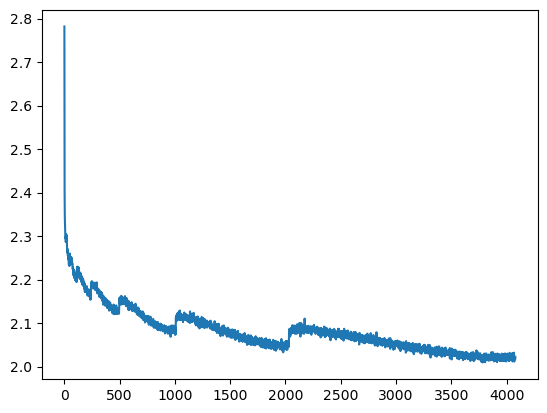

In [73]:
plt.plot(np.arange(len(Train)),Train)

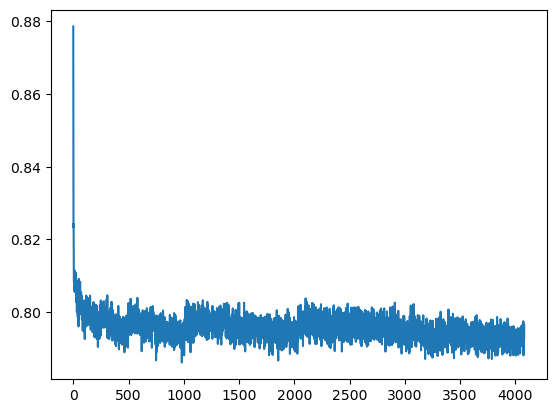

In [74]:
plt.plot(np.arange(len(Eval)),Eval)

In [75]:
fname = "models/stateATT_4L_fixed.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7223265171051025

EVALUATING ON TEST DATA : 
score_test = 0.8075515031814575

EVALUATING ON VAL DATA : 
score_val = 0.7921802997589111



In [76]:
fname = "models/stateATT_4L_fixed_best.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7441562414169312

EVALUATING ON TEST DATA : 
score_test = 0.8092960715293884

EVALUATING ON VAL DATA : 
score_val = 0.7950857877731323



In [77]:
params = get_params(32,5,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/stateATT_5L_fixed.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.7893388271331787, val_loss = 0.8839114904403687
epoch n°1 : train_loss = 2.4898018836975098, val_loss = 0.8373404145240784
epoch n°2 : train_loss = 2.390526294708252, val_loss = 0.8265328407287598
epoch n°3 : train_loss = 2.3613243103027344, val_loss = 0.8177996873855591
epoch n°4 : train_loss = 2.3465216159820557, val_loss = 0.8149544596672058
epoch n°5 : train_loss = 2.3262195587158203, val_loss = 0.8174319267272949
epoch n°6 : train_loss = 2.3259148597717285, val_loss = 0.8157039284706116
epoch n°7 : train_loss = 2.326080799102783, val_loss = 0.8144814968109131
epoch n°8 : train_loss = 2.3109731674194336, val_loss = 0.811331033706665
epoch n°9 : train_loss = 2.3017523288726807, val_loss = 0.810633659362793
epoch n°10 : train_loss = 2.298412322998047, val_loss = 0.8130637407302856
epoch n°11 : train_loss = 2.295822858810425, val_loss = 0.8089595437049866
epoch n°12 : train_loss = 2.2931954860687256, val_loss = 0.8039268851280212
epoch n°13 : train_loss = 2.

epoch n°109 : train_loss = 2.2077887058258057, val_loss = 0.7981290817260742
epoch n°110 : train_loss = 2.19580078125, val_loss = 0.7910687327384949
epoch n°111 : train_loss = 2.195767641067505, val_loss = 0.7927121520042419
epoch n°112 : train_loss = 2.2199482917785645, val_loss = 0.8004888892173767
epoch n°113 : train_loss = 2.219757080078125, val_loss = 0.8028534650802612
epoch n°114 : train_loss = 2.2275664806365967, val_loss = 0.7997846603393555
epoch n°115 : train_loss = 2.2217085361480713, val_loss = 0.8028562664985657
epoch n°116 : train_loss = 2.225337028503418, val_loss = 0.7983916997909546
epoch n°117 : train_loss = 2.224213123321533, val_loss = 0.8058229684829712
epoch n°118 : train_loss = 2.2159183025360107, val_loss = 0.7965304255485535
epoch n°119 : train_loss = 2.222975254058838, val_loss = 0.7993043661117554
epoch n°120 : train_loss = 2.2240231037139893, val_loss = 0.8014844059944153
epoch n°121 : train_loss = 2.2223763465881348, val_loss = 0.8041383624076843
epoch n°1

epoch n°217 : train_loss = 2.1714529991149902, val_loss = 0.7947762608528137
epoch n°218 : train_loss = 2.16259503364563, val_loss = 0.7965410351753235
epoch n°219 : train_loss = 2.163959503173828, val_loss = 0.7942761182785034
epoch n°220 : train_loss = 2.175962209701538, val_loss = 0.7930330038070679
epoch n°221 : train_loss = 2.1706016063690186, val_loss = 0.7956581115722656
epoch n°222 : train_loss = 2.1627562046051025, val_loss = 0.7975071668624878
epoch n°223 : train_loss = 2.1708924770355225, val_loss = 0.793503999710083
epoch n°224 : train_loss = 2.1674094200134277, val_loss = 0.7983896732330322
epoch n°225 : train_loss = 2.16163969039917, val_loss = 0.7964968681335449
epoch n°226 : train_loss = 2.161153793334961, val_loss = 0.7957410216331482
epoch n°227 : train_loss = 2.16245436668396, val_loss = 0.7898058891296387
epoch n°228 : train_loss = 2.1568570137023926, val_loss = 0.7924051284790039
epoch n°229 : train_loss = 2.1658012866973877, val_loss = 0.797581672668457
epoch n°23

epoch n°325 : train_loss = 2.171231985092163, val_loss = 0.7984471917152405
epoch n°326 : train_loss = 2.1702802181243896, val_loss = 0.7958157062530518
epoch n°327 : train_loss = 2.1684372425079346, val_loss = 0.7941774129867554
epoch n°328 : train_loss = 2.1715078353881836, val_loss = 0.7973924279212952
epoch n°329 : train_loss = 2.160848379135132, val_loss = 0.8007664680480957
epoch n°330 : train_loss = 2.162865400314331, val_loss = 0.8000602126121521
epoch n°331 : train_loss = 2.162724494934082, val_loss = 0.7952494621276855
epoch n°332 : train_loss = 2.160372018814087, val_loss = 0.7970333099365234
epoch n°333 : train_loss = 2.1574959754943848, val_loss = 0.7973373532295227
epoch n°334 : train_loss = 2.1662521362304688, val_loss = 0.8012180328369141
epoch n°335 : train_loss = 2.1610734462738037, val_loss = 0.7953050136566162
epoch n°336 : train_loss = 2.166476011276245, val_loss = 0.7972519397735596
epoch n°337 : train_loss = 2.1666955947875977, val_loss = 0.7956675291061401
epoch

epoch n°433 : train_loss = 2.1327576637268066, val_loss = 0.7962858080863953
epoch n°434 : train_loss = 2.127346992492676, val_loss = 0.7945098876953125
epoch n°435 : train_loss = 2.1321144104003906, val_loss = 0.797280490398407
epoch n°436 : train_loss = 2.1337358951568604, val_loss = 0.7950136661529541
epoch n°437 : train_loss = 2.1380555629730225, val_loss = 0.7926307916641235
epoch n°438 : train_loss = 2.12937068939209, val_loss = 0.7967123985290527
epoch n°439 : train_loss = 2.1312339305877686, val_loss = 0.7921052575111389
epoch n°440 : train_loss = 2.1264288425445557, val_loss = 0.7962164878845215
epoch n°441 : train_loss = 2.1314918994903564, val_loss = 0.7994046807289124
epoch n°442 : train_loss = 2.1300771236419678, val_loss = 0.7979183197021484
epoch n°443 : train_loss = 2.1387085914611816, val_loss = 0.7974043488502502
epoch n°444 : train_loss = 2.130009412765503, val_loss = 0.7951362133026123
epoch n°445 : train_loss = 2.13191294670105, val_loss = 0.7953706383705139
epoch 

epoch n°541 : train_loss = 2.1460824012756348, val_loss = 0.7968258857727051
epoch n°542 : train_loss = 2.1466314792633057, val_loss = 0.7959109544754028
epoch n°543 : train_loss = 2.152994394302368, val_loss = 0.7971335649490356
epoch n°544 : train_loss = 2.1454012393951416, val_loss = 0.7996086478233337
epoch n°545 : train_loss = 2.1504454612731934, val_loss = 0.8012098073959351
epoch n°546 : train_loss = 2.1449639797210693, val_loss = 0.7984911799430847
epoch n°547 : train_loss = 2.154914140701294, val_loss = 0.7976940274238586
epoch n°548 : train_loss = 2.146500825881958, val_loss = 0.7946913838386536
epoch n°549 : train_loss = 2.153780698776245, val_loss = 0.7984902262687683
epoch n°550 : train_loss = 2.152303457260132, val_loss = 0.7983263731002808
epoch n°551 : train_loss = 2.163076162338257, val_loss = 0.7988974452018738
epoch n°552 : train_loss = 2.1491785049438477, val_loss = 0.7965046167373657
epoch n°553 : train_loss = 2.153499126434326, val_loss = 0.796617329120636
epoch n

epoch n°649 : train_loss = 2.1285977363586426, val_loss = 0.8003093004226685
epoch n°650 : train_loss = 2.131225824356079, val_loss = 0.7955506443977356
epoch n°651 : train_loss = 2.1260128021240234, val_loss = 0.800746500492096
epoch n°652 : train_loss = 2.1265673637390137, val_loss = 0.7950026392936707
epoch n°653 : train_loss = 2.1287968158721924, val_loss = 0.7932735085487366
epoch n°654 : train_loss = 2.133496046066284, val_loss = 0.7995939254760742
epoch n°655 : train_loss = 2.1297240257263184, val_loss = 0.795788049697876
epoch n°656 : train_loss = 2.1249823570251465, val_loss = 0.794378936290741
epoch n°657 : train_loss = 2.122936248779297, val_loss = 0.7957945466041565
epoch n°658 : train_loss = 2.1354129314422607, val_loss = 0.7969191670417786
epoch n°659 : train_loss = 2.126760721206665, val_loss = 0.792942464351654
epoch n°660 : train_loss = 2.119473934173584, val_loss = 0.7955562472343445
epoch n°661 : train_loss = 2.129974603652954, val_loss = 0.7982526421546936
epoch n°6

epoch n°757 : train_loss = 2.1118052005767822, val_loss = 0.7914087772369385
epoch n°758 : train_loss = 2.102585792541504, val_loss = 0.7938733696937561
epoch n°759 : train_loss = 2.1011946201324463, val_loss = 0.795521080493927
epoch n°760 : train_loss = 2.098843574523926, val_loss = 0.7955009341239929
epoch n°761 : train_loss = 2.107776403427124, val_loss = 0.7955762147903442
epoch n°762 : train_loss = 2.101983070373535, val_loss = 0.7967072129249573
epoch n°763 : train_loss = 2.1047921180725098, val_loss = 0.7951056361198425
epoch n°764 : train_loss = 2.1156134605407715, val_loss = 0.794945478439331
epoch n°765 : train_loss = 2.108927011489868, val_loss = 0.7961836457252502
epoch n°766 : train_loss = 2.1074931621551514, val_loss = 0.7948161363601685
epoch n°767 : train_loss = 2.1075217723846436, val_loss = 0.7953230738639832
epoch n°768 : train_loss = 2.1068599224090576, val_loss = 0.7967889308929443
epoch n°769 : train_loss = 2.1046125888824463, val_loss = 0.7956051230430603
epoch 

epoch n°865 : train_loss = 2.0891072750091553, val_loss = 0.796015739440918
epoch n°866 : train_loss = 2.090073347091675, val_loss = 0.7931612730026245
epoch n°867 : train_loss = 2.087911605834961, val_loss = 0.7915206551551819
epoch n°868 : train_loss = 2.0954997539520264, val_loss = 0.7928173542022705
epoch n°869 : train_loss = 2.0786361694335938, val_loss = 0.7947854399681091
epoch n°870 : train_loss = 2.0899531841278076, val_loss = 0.7946581840515137
epoch n°871 : train_loss = 2.0917727947235107, val_loss = 0.7929120063781738
epoch n°872 : train_loss = 2.0969481468200684, val_loss = 0.7924547791481018
epoch n°873 : train_loss = 2.0909101963043213, val_loss = 0.7892622351646423
epoch n°874 : train_loss = 2.091083288192749, val_loss = 0.7951991558074951
epoch n°875 : train_loss = 2.0858850479125977, val_loss = 0.7951076626777649
epoch n°876 : train_loss = 2.0871386528015137, val_loss = 0.7969390749931335
epoch n°877 : train_loss = 2.082737922668457, val_loss = 0.7916211485862732
epoc

epoch n°973 : train_loss = 2.0807435512542725, val_loss = 0.7913111448287964
epoch n°974 : train_loss = 2.080427646636963, val_loss = 0.7943079471588135
epoch n°975 : train_loss = 2.08441424369812, val_loss = 0.7921202778816223
epoch n°976 : train_loss = 2.079874277114868, val_loss = 0.7922267317771912
epoch n°977 : train_loss = 2.0800249576568604, val_loss = 0.7899177670478821
epoch n°978 : train_loss = 2.0826973915100098, val_loss = 0.7942233681678772
epoch n°979 : train_loss = 2.0790364742279053, val_loss = 0.7937131524085999
epoch n°980 : train_loss = 2.0773496627807617, val_loss = 0.7912003993988037
epoch n°981 : train_loss = 2.0757811069488525, val_loss = 0.7882147431373596
epoch n°982 : train_loss = 2.075315237045288, val_loss = 0.7953120470046997
epoch n°983 : train_loss = 2.077910900115967, val_loss = 0.7933682203292847
epoch n°984 : train_loss = 2.083664655685425, val_loss = 0.7914401292800903
epoch n°985 : train_loss = 2.087423324584961, val_loss = 0.7946136593818665
epoch n

epoch n°1080 : train_loss = 2.118396043777466, val_loss = 0.7952908873558044
epoch n°1081 : train_loss = 2.1148664951324463, val_loss = 0.7966376543045044
epoch n°1082 : train_loss = 2.1215274333953857, val_loss = 0.7963247895240784
epoch n°1083 : train_loss = 2.1174674034118652, val_loss = 0.7973765134811401
epoch n°1084 : train_loss = 2.1133625507354736, val_loss = 0.798900842666626
epoch n°1085 : train_loss = 2.1098124980926514, val_loss = 0.7953512072563171
epoch n°1086 : train_loss = 2.1099581718444824, val_loss = 0.7982258796691895
epoch n°1087 : train_loss = 2.1105308532714844, val_loss = 0.7939500212669373
epoch n°1088 : train_loss = 2.1157331466674805, val_loss = 0.7940219044685364
epoch n°1089 : train_loss = 2.121769666671753, val_loss = 0.7975455522537231
epoch n°1090 : train_loss = 2.120384454727173, val_loss = 0.7983177900314331
epoch n°1091 : train_loss = 2.1141088008880615, val_loss = 0.7989121675491333
epoch n°1092 : train_loss = 2.117875337600708, val_loss = 0.79879260

epoch n°1186 : train_loss = 2.1102447509765625, val_loss = 0.7909876108169556
epoch n°1187 : train_loss = 2.1137287616729736, val_loss = 0.8002837896347046
epoch n°1188 : train_loss = 2.1147797107696533, val_loss = 0.7977218627929688
epoch n°1189 : train_loss = 2.1151909828186035, val_loss = 0.7978308200836182
epoch n°1190 : train_loss = 2.110332727432251, val_loss = 0.7953202724456787
epoch n°1191 : train_loss = 2.104767322540283, val_loss = 0.7937140464782715
epoch n°1192 : train_loss = 2.103728771209717, val_loss = 0.7984472513198853
epoch n°1193 : train_loss = 2.100921630859375, val_loss = 0.7955068349838257
epoch n°1194 : train_loss = 2.1061623096466064, val_loss = 0.7954395413398743
epoch n°1195 : train_loss = 2.105813980102539, val_loss = 0.7915809154510498
epoch n°1196 : train_loss = 2.109797716140747, val_loss = 0.7956885099411011
epoch n°1197 : train_loss = 2.102970838546753, val_loss = 0.7978602647781372
epoch n°1198 : train_loss = 2.106682300567627, val_loss = 0.80188679695

epoch n°1292 : train_loss = 2.0897867679595947, val_loss = 0.79648357629776
epoch n°1293 : train_loss = 2.095048427581787, val_loss = 0.7987921833992004
epoch n°1294 : train_loss = 2.096526622772217, val_loss = 0.7982348203659058
epoch n°1295 : train_loss = 2.0956876277923584, val_loss = 0.7961321473121643
epoch n°1296 : train_loss = 2.0806145668029785, val_loss = 0.7900908589363098
epoch n°1297 : train_loss = 2.0906360149383545, val_loss = 0.7968196272850037
epoch n°1298 : train_loss = 2.098008394241333, val_loss = 0.7958675622940063
epoch n°1299 : train_loss = 2.0953805446624756, val_loss = 0.7906678915023804
epoch n°1300 : train_loss = 2.0997376441955566, val_loss = 0.7932131290435791
epoch n°1301 : train_loss = 2.092089891433716, val_loss = 0.7981998324394226
epoch n°1302 : train_loss = 2.098555564880371, val_loss = 0.7943008542060852
epoch n°1303 : train_loss = 2.1045114994049072, val_loss = 0.7990081310272217
epoch n°1304 : train_loss = 2.0978612899780273, val_loss = 0.7959485650

epoch n°1398 : train_loss = 2.0755786895751953, val_loss = 0.7948784232139587
epoch n°1399 : train_loss = 2.0810177326202393, val_loss = 0.7961321473121643
epoch n°1400 : train_loss = 2.083085536956787, val_loss = 0.7933714389801025
epoch n°1401 : train_loss = 2.0832555294036865, val_loss = 0.7979635000228882
epoch n°1402 : train_loss = 2.0811407566070557, val_loss = 0.7945514917373657
epoch n°1403 : train_loss = 2.090336561203003, val_loss = 0.7908786535263062
epoch n°1404 : train_loss = 2.0727434158325195, val_loss = 0.7969651222229004
epoch n°1405 : train_loss = 2.0865299701690674, val_loss = 0.7943229079246521
epoch n°1406 : train_loss = 2.0799965858459473, val_loss = 0.7937803864479065
epoch n°1407 : train_loss = 2.088902473449707, val_loss = 0.7994890213012695
epoch n°1408 : train_loss = 2.0820491313934326, val_loss = 0.7954838871955872
epoch n°1409 : train_loss = 2.085573673248291, val_loss = 0.7914484739303589
epoch n°1410 : train_loss = 2.0754287242889404, val_loss = 0.7945737

epoch n°1504 : train_loss = 2.0805022716522217, val_loss = 0.7919948101043701
epoch n°1505 : train_loss = 2.0759804248809814, val_loss = 0.793653666973114
epoch n°1506 : train_loss = 2.068202018737793, val_loss = 0.7967839241027832
epoch n°1507 : train_loss = 2.0686070919036865, val_loss = 0.7930369973182678
epoch n°1508 : train_loss = 2.074924945831299, val_loss = 0.7952510118484497
epoch n°1509 : train_loss = 2.0784404277801514, val_loss = 0.7926990985870361
epoch n°1510 : train_loss = 2.0729868412017822, val_loss = 0.7963452339172363
epoch n°1511 : train_loss = 2.0786118507385254, val_loss = 0.7989960312843323
epoch n°1512 : train_loss = 2.066610336303711, val_loss = 0.7943823337554932
epoch n°1513 : train_loss = 2.081754446029663, val_loss = 0.7949397563934326
epoch n°1514 : train_loss = 2.0806214809417725, val_loss = 0.794717013835907
epoch n°1515 : train_loss = 2.0795340538024902, val_loss = 0.7937161326408386
epoch n°1516 : train_loss = 2.0775349140167236, val_loss = 0.793953955

epoch n°1610 : train_loss = 2.065650463104248, val_loss = 0.7924673557281494
epoch n°1611 : train_loss = 2.064899444580078, val_loss = 0.7915642857551575
epoch n°1612 : train_loss = 2.059776544570923, val_loss = 0.7918389439582825
epoch n°1613 : train_loss = 2.0567123889923096, val_loss = 0.7938201427459717
epoch n°1614 : train_loss = 2.061237335205078, val_loss = 0.7929803133010864
epoch n°1615 : train_loss = 2.059628486633301, val_loss = 0.7933230400085449
epoch n°1616 : train_loss = 2.0658199787139893, val_loss = 0.7923156023025513
epoch n°1617 : train_loss = 2.065325975418091, val_loss = 0.7930849194526672
epoch n°1618 : train_loss = 2.0621790885925293, val_loss = 0.7925106287002563
epoch n°1619 : train_loss = 2.0606822967529297, val_loss = 0.7943443655967712
epoch n°1620 : train_loss = 2.056267261505127, val_loss = 0.7959619760513306
epoch n°1621 : train_loss = 2.05960750579834, val_loss = 0.7932773232460022
epoch n°1622 : train_loss = 2.06494402885437, val_loss = 0.79442268610000

epoch n°1717 : train_loss = 2.068243980407715, val_loss = 0.7936872243881226
epoch n°1718 : train_loss = 2.0562968254089355, val_loss = 0.7965421080589294
epoch n°1719 : train_loss = 2.0535271167755127, val_loss = 0.7919670343399048
epoch n°1720 : train_loss = 2.0548095703125, val_loss = 0.7939345240592957
epoch n°1721 : train_loss = 2.0560076236724854, val_loss = 0.7945517897605896
epoch n°1722 : train_loss = 2.0515875816345215, val_loss = 0.7918714880943298
epoch n°1723 : train_loss = 2.0615830421447754, val_loss = 0.7925341725349426
epoch n°1724 : train_loss = 2.0540661811828613, val_loss = 0.7936169505119324
epoch n°1725 : train_loss = 2.052110433578491, val_loss = 0.7926763296127319
epoch n°1726 : train_loss = 2.0593767166137695, val_loss = 0.7964803576469421
epoch n°1727 : train_loss = 2.053755283355713, val_loss = 0.7946432828903198
epoch n°1728 : train_loss = 2.050009250640869, val_loss = 0.7958309650421143
epoch n°1729 : train_loss = 2.056324005126953, val_loss = 0.79436343908

epoch n°1823 : train_loss = 2.044855833053589, val_loss = 0.7924646139144897
epoch n°1824 : train_loss = 2.056574821472168, val_loss = 0.7925589680671692
epoch n°1825 : train_loss = 2.040947198867798, val_loss = 0.7947389483451843
epoch n°1826 : train_loss = 2.0458805561065674, val_loss = 0.7934871912002563
epoch n°1827 : train_loss = 2.0536797046661377, val_loss = 0.7895676493644714
epoch n°1828 : train_loss = 2.0531296730041504, val_loss = 0.7937980890274048
epoch n°1829 : train_loss = 2.047450065612793, val_loss = 0.7917565703392029
epoch n°1830 : train_loss = 2.0483648777008057, val_loss = 0.7953317761421204
epoch n°1831 : train_loss = 2.0499980449676514, val_loss = 0.7926672101020813
epoch n°1832 : train_loss = 2.048748254776001, val_loss = 0.7919589281082153
epoch n°1833 : train_loss = 2.051140785217285, val_loss = 0.792823851108551
epoch n°1834 : train_loss = 2.0579593181610107, val_loss = 0.7941624522209167
epoch n°1835 : train_loss = 2.053013801574707, val_loss = 0.79498070478

epoch n°1929 : train_loss = 2.0492196083068848, val_loss = 0.7900041341781616
epoch n°1930 : train_loss = 2.050733804702759, val_loss = 0.7920708060264587
epoch n°1931 : train_loss = 2.0534536838531494, val_loss = 0.7978560924530029
epoch n°1932 : train_loss = 2.041900157928467, val_loss = 0.789429783821106
epoch n°1933 : train_loss = 2.0497426986694336, val_loss = 0.7912083268165588
epoch n°1934 : train_loss = 2.0493359565734863, val_loss = 0.7927737832069397
epoch n°1935 : train_loss = 2.048037052154541, val_loss = 0.7936314940452576
epoch n°1936 : train_loss = 2.0467512607574463, val_loss = 0.7922686338424683
epoch n°1937 : train_loss = 2.05639386177063, val_loss = 0.7892985343933105
epoch n°1938 : train_loss = 2.05220890045166, val_loss = 0.7949965000152588
epoch n°1939 : train_loss = 2.0474226474761963, val_loss = 0.7970625162124634
epoch n°1940 : train_loss = 2.045362949371338, val_loss = 0.7897254824638367
epoch n°1941 : train_loss = 2.0555222034454346, val_loss = 0.791263639926

epoch n°2035 : train_loss = 2.062694549560547, val_loss = 0.795486569404602
epoch n°2036 : train_loss = 2.07812237739563, val_loss = 0.7945098876953125
epoch n°2037 : train_loss = 2.087322950363159, val_loss = 0.797387957572937
epoch n°2038 : train_loss = 2.0718681812286377, val_loss = 0.7940722107887268
epoch n°2039 : train_loss = 2.072890043258667, val_loss = 0.7942395210266113
epoch n°2040 : train_loss = 2.0829765796661377, val_loss = 0.7960038781166077
epoch n°2041 : train_loss = 2.080418109893799, val_loss = 0.7960658073425293
epoch n°2042 : train_loss = 2.077899217605591, val_loss = 0.7981109023094177
epoch n°2043 : train_loss = 2.078753709793091, val_loss = 0.7972661852836609
epoch n°2044 : train_loss = 2.0836896896362305, val_loss = 0.7975793480873108
epoch n°2045 : train_loss = 2.0757243633270264, val_loss = 0.795183002948761
epoch n°2046 : train_loss = 2.0846521854400635, val_loss = 0.7998738884925842
epoch n°2047 : train_loss = 2.079918622970581, val_loss = 0.795665919780731

epoch n°2141 : train_loss = 2.1006524562835693, val_loss = 0.7955430150032043
epoch n°2142 : train_loss = 2.085550308227539, val_loss = 0.7994588017463684
epoch n°2143 : train_loss = 2.0847437381744385, val_loss = 0.7939640879631042
epoch n°2144 : train_loss = 2.0834696292877197, val_loss = 0.7955076694488525
epoch n°2145 : train_loss = 2.08636212348938, val_loss = 0.7932680249214172
epoch n°2146 : train_loss = 2.0848186016082764, val_loss = 0.796501100063324
epoch n°2147 : train_loss = 2.0854649543762207, val_loss = 0.7957290410995483
epoch n°2148 : train_loss = 2.083879232406616, val_loss = 0.8011038899421692
epoch n°2149 : train_loss = 2.0916810035705566, val_loss = 0.7975564002990723
epoch n°2150 : train_loss = 2.082120895385742, val_loss = 0.792329728603363
epoch n°2151 : train_loss = 2.0919365882873535, val_loss = 0.7914286851882935
epoch n°2152 : train_loss = 2.0900309085845947, val_loss = 0.7928786873817444
epoch n°2153 : train_loss = 2.0877888202667236, val_loss = 0.7962682843

epoch n°2247 : train_loss = 2.086789846420288, val_loss = 0.796997606754303
epoch n°2248 : train_loss = 2.0809524059295654, val_loss = 0.7982658743858337
epoch n°2249 : train_loss = 2.079645872116089, val_loss = 0.7894875407218933
epoch n°2250 : train_loss = 2.072305917739868, val_loss = 0.7922650575637817
epoch n°2251 : train_loss = 2.0824389457702637, val_loss = 0.7944534420967102
epoch n°2252 : train_loss = 2.0830092430114746, val_loss = 0.7984733581542969
epoch n°2253 : train_loss = 2.094104051589966, val_loss = 0.79765385389328
epoch n°2254 : train_loss = 2.0842816829681396, val_loss = 0.7939919233322144
epoch n°2255 : train_loss = 2.086811065673828, val_loss = 0.7954715490341187
epoch n°2256 : train_loss = 2.0804712772369385, val_loss = 0.798409104347229
epoch n°2257 : train_loss = 2.078476667404175, val_loss = 0.7907283902168274
epoch n°2258 : train_loss = 2.0816640853881836, val_loss = 0.7903569936752319
epoch n°2259 : train_loss = 2.079854726791382, val_loss = 0.79422628879547

epoch n°2353 : train_loss = 2.07436466217041, val_loss = 0.7929233908653259
epoch n°2354 : train_loss = 2.080721139907837, val_loss = 0.7948721647262573
epoch n°2355 : train_loss = 2.082836389541626, val_loss = 0.7957271933555603
epoch n°2356 : train_loss = 2.0823817253112793, val_loss = 0.7966898679733276
epoch n°2357 : train_loss = 2.076502799987793, val_loss = 0.7994319200515747
epoch n°2358 : train_loss = 2.0797653198242188, val_loss = 0.7907552719116211
epoch n°2359 : train_loss = 2.0758159160614014, val_loss = 0.7983647584915161
epoch n°2360 : train_loss = 2.0830225944519043, val_loss = 0.7997296452522278
epoch n°2361 : train_loss = 2.069087505340576, val_loss = 0.7946821451187134
epoch n°2362 : train_loss = 2.080655097961426, val_loss = 0.8000028133392334
epoch n°2363 : train_loss = 2.0789341926574707, val_loss = 0.795431911945343
epoch n°2364 : train_loss = 2.076141595840454, val_loss = 0.7931331992149353
epoch n°2365 : train_loss = 2.0787405967712402, val_loss = 0.795559704303

epoch n°2460 : train_loss = 2.0771753787994385, val_loss = 0.7974385619163513
epoch n°2461 : train_loss = 2.068376064300537, val_loss = 0.7905205488204956
epoch n°2462 : train_loss = 2.0702261924743652, val_loss = 0.7956539392471313
epoch n°2463 : train_loss = 2.0686655044555664, val_loss = 0.7981555461883545
epoch n°2464 : train_loss = 2.072016716003418, val_loss = 0.7933168411254883
epoch n°2465 : train_loss = 2.076005220413208, val_loss = 0.7985706329345703
epoch n°2466 : train_loss = 2.0703916549682617, val_loss = 0.7917314767837524
epoch n°2467 : train_loss = 2.0780584812164307, val_loss = 0.7924384474754333
epoch n°2468 : train_loss = 2.0728657245635986, val_loss = 0.7935881018638611
epoch n°2469 : train_loss = 2.0756149291992188, val_loss = 0.7981774210929871
epoch n°2470 : train_loss = 2.0790607929229736, val_loss = 0.7906035780906677
epoch n°2471 : train_loss = 2.0674915313720703, val_loss = 0.7933405637741089
epoch n°2472 : train_loss = 2.0763349533081055, val_loss = 0.794909

epoch n°2566 : train_loss = 2.062581777572632, val_loss = 0.7958925366401672
epoch n°2567 : train_loss = 2.0672428607940674, val_loss = 0.7950834035873413
epoch n°2568 : train_loss = 2.0619513988494873, val_loss = 0.8018878102302551
epoch n°2569 : train_loss = 2.06235408782959, val_loss = 0.7915725708007812
epoch n°2570 : train_loss = 2.0675909519195557, val_loss = 0.7968552112579346
epoch n°2571 : train_loss = 2.0710771083831787, val_loss = 0.7924591302871704
epoch n°2572 : train_loss = 2.0630412101745605, val_loss = 0.794274091720581
epoch n°2573 : train_loss = 2.065228223800659, val_loss = 0.8001793622970581
epoch n°2574 : train_loss = 2.0637123584747314, val_loss = 0.7958373427391052
epoch n°2575 : train_loss = 2.0672237873077393, val_loss = 0.7990629076957703
epoch n°2576 : train_loss = 2.066303014755249, val_loss = 0.7980601787567139
epoch n°2577 : train_loss = 2.067595958709717, val_loss = 0.7987068295478821
epoch n°2578 : train_loss = 2.0656466484069824, val_loss = 0.7991995811

epoch n°2672 : train_loss = 2.067476987838745, val_loss = 0.7987282276153564
epoch n°2673 : train_loss = 2.0590145587921143, val_loss = 0.7916828989982605
epoch n°2674 : train_loss = 2.058492660522461, val_loss = 0.7931827306747437
epoch n°2675 : train_loss = 2.0639686584472656, val_loss = 0.7932569980621338
epoch n°2676 : train_loss = 2.060399055480957, val_loss = 0.7952693700790405
epoch n°2677 : train_loss = 2.0497164726257324, val_loss = 0.7937905788421631
epoch n°2678 : train_loss = 2.0587716102600098, val_loss = 0.7951778173446655
epoch n°2679 : train_loss = 2.0672085285186768, val_loss = 0.7937468886375427
epoch n°2680 : train_loss = 2.069793462753296, val_loss = 0.7865792512893677
epoch n°2681 : train_loss = 2.06154465675354, val_loss = 0.7893362641334534
epoch n°2682 : train_loss = 2.063958168029785, val_loss = 0.7979415059089661
epoch n°2683 : train_loss = 2.0671226978302, val_loss = 0.7968992590904236
epoch n°2684 : train_loss = 2.0633697509765625, val_loss = 0.7904786467552

epoch n°2778 : train_loss = 2.0581424236297607, val_loss = 0.791713297367096
epoch n°2779 : train_loss = 2.0649468898773193, val_loss = 0.793591320514679
epoch n°2780 : train_loss = 2.04803729057312, val_loss = 0.7946167588233948
epoch n°2781 : train_loss = 2.0623667240142822, val_loss = 0.793396532535553
epoch n°2782 : train_loss = 2.060593843460083, val_loss = 0.7937297224998474
epoch n°2783 : train_loss = 2.061028003692627, val_loss = 0.7939335703849792
epoch n°2784 : train_loss = 2.054239511489868, val_loss = 0.7976046800613403
epoch n°2785 : train_loss = 2.0586798191070557, val_loss = 0.7903836369514465
epoch n°2786 : train_loss = 2.0632996559143066, val_loss = 0.7923145890235901
epoch n°2787 : train_loss = 2.0629591941833496, val_loss = 0.7924433350563049
epoch n°2788 : train_loss = 2.0579333305358887, val_loss = 0.7932413816452026
epoch n°2789 : train_loss = 2.0546865463256836, val_loss = 0.7989276051521301
epoch n°2790 : train_loss = 2.0533363819122314, val_loss = 0.79922419786

epoch n°2885 : train_loss = 2.0531113147735596, val_loss = 0.7931883931159973
epoch n°2886 : train_loss = 2.0517892837524414, val_loss = 0.7921643853187561
epoch n°2887 : train_loss = 2.0501046180725098, val_loss = 0.7912037968635559
epoch n°2888 : train_loss = 2.0550155639648438, val_loss = 0.7982395887374878
epoch n°2889 : train_loss = 2.0504813194274902, val_loss = 0.7962189316749573
epoch n°2890 : train_loss = 2.056983470916748, val_loss = 0.789268970489502
epoch n°2891 : train_loss = 2.047243356704712, val_loss = 0.7963753342628479
epoch n°2892 : train_loss = 2.052450180053711, val_loss = 0.7955403327941895
epoch n°2893 : train_loss = 2.0532009601593018, val_loss = 0.7952909469604492
epoch n°2894 : train_loss = 2.0516459941864014, val_loss = 0.792922854423523
epoch n°2895 : train_loss = 2.0499703884124756, val_loss = 0.7972187995910645
epoch n°2896 : train_loss = 2.0557448863983154, val_loss = 0.7958849668502808
epoch n°2897 : train_loss = 2.059962034225464, val_loss = 0.793839633

epoch n°2991 : train_loss = 2.05172061920166, val_loss = 0.7945701479911804
epoch n°2992 : train_loss = 2.043924570083618, val_loss = 0.7928577065467834
epoch n°2993 : train_loss = 2.053943634033203, val_loss = 0.7941602468490601
epoch n°2994 : train_loss = 2.045875072479248, val_loss = 0.7928969264030457
epoch n°2995 : train_loss = 2.050640106201172, val_loss = 0.7907989025115967
epoch n°2996 : train_loss = 2.0459203720092773, val_loss = 0.7951367497444153
epoch n°2997 : train_loss = 2.0508739948272705, val_loss = 0.7983592748641968
epoch n°2998 : train_loss = 2.0526583194732666, val_loss = 0.7959936261177063
epoch n°2999 : train_loss = 2.0432205200195312, val_loss = 0.7963268756866455
epoch n°3000 : train_loss = 2.0467076301574707, val_loss = 0.7963128089904785
epoch n°3001 : train_loss = 2.042295217514038, val_loss = 0.7955003976821899
epoch n°3002 : train_loss = 2.050311326980591, val_loss = 0.7908007502555847
epoch n°3003 : train_loss = 2.0436320304870605, val_loss = 0.79181402921

epoch n°3097 : train_loss = 2.0345020294189453, val_loss = 0.7993793487548828
epoch n°3098 : train_loss = 2.0439462661743164, val_loss = 0.7901510000228882
epoch n°3099 : train_loss = 2.0488240718841553, val_loss = 0.793315589427948
epoch n°3100 : train_loss = 2.0315444469451904, val_loss = 0.7952379584312439
epoch n°3101 : train_loss = 2.0407252311706543, val_loss = 0.7889896631240845
epoch n°3102 : train_loss = 2.047902822494507, val_loss = 0.7946640849113464
epoch n°3103 : train_loss = 2.0317208766937256, val_loss = 0.7902134656906128
epoch n°3104 : train_loss = 2.043222665786743, val_loss = 0.7913590669631958
epoch n°3105 : train_loss = 2.041168689727783, val_loss = 0.7890458703041077
epoch n°3106 : train_loss = 2.041179895401001, val_loss = 0.7925271391868591
epoch n°3107 : train_loss = 2.036102533340454, val_loss = 0.7925128936767578
epoch n°3108 : train_loss = 2.0402493476867676, val_loss = 0.7934216856956482
epoch n°3109 : train_loss = 2.0456793308258057, val_loss = 0.792185664

epoch n°3203 : train_loss = 2.040743589401245, val_loss = 0.7905868887901306
epoch n°3204 : train_loss = 2.0396103858947754, val_loss = 0.7936487197875977
epoch n°3205 : train_loss = 2.041027784347534, val_loss = 0.7947460412979126
epoch n°3206 : train_loss = 2.0379350185394287, val_loss = 0.7907794713973999
epoch n°3207 : train_loss = 2.0359487533569336, val_loss = 0.7941707372665405
epoch n°3208 : train_loss = 2.0349786281585693, val_loss = 0.7915663123130798
epoch n°3209 : train_loss = 2.0326948165893555, val_loss = 0.7959595322608948
epoch n°3210 : train_loss = 2.0390782356262207, val_loss = 0.7923293113708496
epoch n°3211 : train_loss = 2.0352039337158203, val_loss = 0.7918460369110107
epoch n°3212 : train_loss = 2.0284183025360107, val_loss = 0.7911098599433899
epoch n°3213 : train_loss = 2.04606294631958, val_loss = 0.795337975025177
epoch n°3214 : train_loss = 2.0379767417907715, val_loss = 0.7929864525794983
epoch n°3215 : train_loss = 2.035945177078247, val_loss = 0.788115262

epoch n°3309 : train_loss = 2.0315921306610107, val_loss = 0.7918734550476074
epoch n°3310 : train_loss = 2.03531813621521, val_loss = 0.7940924763679504
epoch n°3311 : train_loss = 2.039156913757324, val_loss = 0.7935526967048645
epoch n°3312 : train_loss = 2.023803234100342, val_loss = 0.7956115007400513
epoch n°3313 : train_loss = 2.0278797149658203, val_loss = 0.7961307168006897
epoch n°3314 : train_loss = 2.029573678970337, val_loss = 0.7951270937919617
epoch n°3315 : train_loss = 2.040356397628784, val_loss = 0.7905092239379883
epoch n°3316 : train_loss = 2.028373956680298, val_loss = 0.7959811687469482
epoch n°3317 : train_loss = 2.0353100299835205, val_loss = 0.7897055149078369
epoch n°3318 : train_loss = 2.033750295639038, val_loss = 0.7919362783432007
epoch n°3319 : train_loss = 2.0294511318206787, val_loss = 0.7924994826316833
epoch n°3320 : train_loss = 2.0310966968536377, val_loss = 0.7897738814353943
epoch n°3321 : train_loss = 2.0377535820007324, val_loss = 0.78630733489

epoch n°3416 : train_loss = 2.038238048553467, val_loss = 0.7966295480728149
epoch n°3417 : train_loss = 2.0394041538238525, val_loss = 0.7889423966407776
epoch n°3418 : train_loss = 2.026616334915161, val_loss = 0.7876806855201721
epoch n°3419 : train_loss = 2.03572940826416, val_loss = 0.790361762046814
epoch n°3420 : train_loss = 2.029482841491699, val_loss = 0.7954167127609253
epoch n°3421 : train_loss = 2.0228984355926514, val_loss = 0.7934736013412476
epoch n°3422 : train_loss = 2.0330634117126465, val_loss = 0.7929393649101257
epoch n°3423 : train_loss = 2.030689239501953, val_loss = 0.7963622212409973
epoch n°3424 : train_loss = 2.031421661376953, val_loss = 0.7935289740562439
epoch n°3425 : train_loss = 2.0354578495025635, val_loss = 0.7934752702713013
epoch n°3426 : train_loss = 2.0306906700134277, val_loss = 0.7941861748695374
epoch n°3427 : train_loss = 2.0269434452056885, val_loss = 0.7930223345756531
epoch n°3428 : train_loss = 2.0278053283691406, val_loss = 0.79616516828

epoch n°3522 : train_loss = 2.027547597885132, val_loss = 0.7878039479255676
epoch n°3523 : train_loss = 2.0225868225097656, val_loss = 0.7954515814781189
epoch n°3524 : train_loss = 2.0279226303100586, val_loss = 0.7919180393218994
epoch n°3525 : train_loss = 2.026055335998535, val_loss = 0.7923033833503723
epoch n°3526 : train_loss = 2.025651454925537, val_loss = 0.7926830649375916
epoch n°3527 : train_loss = 2.022967576980591, val_loss = 0.7974276542663574
epoch n°3528 : train_loss = 2.031094551086426, val_loss = 0.7953699231147766
epoch n°3529 : train_loss = 2.021524667739868, val_loss = 0.7890104055404663
epoch n°3530 : train_loss = 2.0145344734191895, val_loss = 0.7921067476272583
epoch n°3531 : train_loss = 2.0221331119537354, val_loss = 0.7927387952804565
epoch n°3532 : train_loss = 2.0270001888275146, val_loss = 0.7934428453445435
epoch n°3533 : train_loss = 2.0271999835968018, val_loss = 0.7969607710838318
epoch n°3534 : train_loss = 2.0211281776428223, val_loss = 0.789414703

epoch n°3628 : train_loss = 2.0283212661743164, val_loss = 0.7917956709861755
epoch n°3629 : train_loss = 2.0234804153442383, val_loss = 0.7929254770278931
epoch n°3630 : train_loss = 2.021559953689575, val_loss = 0.7876308560371399
epoch n°3631 : train_loss = 2.022686719894409, val_loss = 0.7926648855209351
epoch n°3632 : train_loss = 2.01955246925354, val_loss = 0.7910313010215759
epoch n°3633 : train_loss = 2.0253379344940186, val_loss = 0.7902359366416931
epoch n°3634 : train_loss = 2.020163059234619, val_loss = 0.7906777262687683
epoch n°3635 : train_loss = 2.014739513397217, val_loss = 0.79071444272995
epoch n°3636 : train_loss = 2.0266919136047363, val_loss = 0.7917569279670715
epoch n°3637 : train_loss = 2.032547950744629, val_loss = 0.7937561869621277
epoch n°3638 : train_loss = 2.0209336280822754, val_loss = 0.7971866726875305
epoch n°3639 : train_loss = 2.0195672512054443, val_loss = 0.7934920191764832
epoch n°3640 : train_loss = 2.021026134490967, val_loss = 0.7945191264152

epoch n°3734 : train_loss = 2.0273241996765137, val_loss = 0.7920435070991516
epoch n°3735 : train_loss = 2.018195152282715, val_loss = 0.7911106944084167
epoch n°3736 : train_loss = 2.0211620330810547, val_loss = 0.7954918146133423
epoch n°3737 : train_loss = 2.018415927886963, val_loss = 0.7935808300971985
epoch n°3738 : train_loss = 2.021836519241333, val_loss = 0.7934287190437317
epoch n°3739 : train_loss = 2.0203118324279785, val_loss = 0.789320707321167
epoch n°3740 : train_loss = 2.0218145847320557, val_loss = 0.7926338911056519
epoch n°3741 : train_loss = 2.031282424926758, val_loss = 0.7874051928520203
epoch n°3742 : train_loss = 2.0161454677581787, val_loss = 0.7923540472984314
epoch n°3743 : train_loss = 2.0135722160339355, val_loss = 0.7898024916648865
epoch n°3744 : train_loss = 2.0183613300323486, val_loss = 0.7894567847251892
epoch n°3745 : train_loss = 2.012097120285034, val_loss = 0.7903531789779663
epoch n°3746 : train_loss = 2.0236709117889404, val_loss = 0.793765962

epoch n°3840 : train_loss = 2.010676383972168, val_loss = 0.7931050062179565
epoch n°3841 : train_loss = 2.0222537517547607, val_loss = 0.7891705632209778
epoch n°3842 : train_loss = 2.0159261226654053, val_loss = 0.7910085916519165
epoch n°3843 : train_loss = 2.010918140411377, val_loss = 0.7940701842308044
epoch n°3844 : train_loss = 2.0136916637420654, val_loss = 0.7944579124450684
epoch n°3845 : train_loss = 2.019195079803467, val_loss = 0.7940580248832703
epoch n°3846 : train_loss = 2.0223958492279053, val_loss = 0.7875478863716125
epoch n°3847 : train_loss = 2.0131211280822754, val_loss = 0.7871554493904114
epoch n°3848 : train_loss = 2.0134165287017822, val_loss = 0.7908666133880615
epoch n°3849 : train_loss = 2.020833969116211, val_loss = 0.7946516871452332
epoch n°3850 : train_loss = 2.013592481613159, val_loss = 0.7923764586448669
epoch n°3851 : train_loss = 2.0166964530944824, val_loss = 0.7944880723953247
epoch n°3852 : train_loss = 2.011226177215576, val_loss = 0.792299091

epoch n°3946 : train_loss = 2.013347625732422, val_loss = 0.7893847823143005
epoch n°3947 : train_loss = 2.01733660697937, val_loss = 0.7888001799583435
epoch n°3948 : train_loss = 2.0163538455963135, val_loss = 0.7920605540275574
epoch n°3949 : train_loss = 2.024801731109619, val_loss = 0.7905817627906799
epoch n°3950 : train_loss = 2.0124475955963135, val_loss = 0.7922951579093933
epoch n°3951 : train_loss = 2.017301321029663, val_loss = 0.793402910232544
epoch n°3952 : train_loss = 2.0085339546203613, val_loss = 0.7931086421012878
epoch n°3953 : train_loss = 2.015597105026245, val_loss = 0.7918294668197632
epoch n°3954 : train_loss = 2.00862717628479, val_loss = 0.7896990180015564
epoch n°3955 : train_loss = 2.0166966915130615, val_loss = 0.7919116616249084
epoch n°3956 : train_loss = 2.0203912258148193, val_loss = 0.788445234298706
epoch n°3957 : train_loss = 2.019946813583374, val_loss = 0.7934084534645081
epoch n°3958 : train_loss = 2.0260207653045654, val_loss = 0.79582792520523

epoch n°4052 : train_loss = 2.0109946727752686, val_loss = 0.794083297252655
epoch n°4053 : train_loss = 2.020913600921631, val_loss = 0.7917900085449219
epoch n°4054 : train_loss = 2.0215468406677246, val_loss = 0.7890529036521912
epoch n°4055 : train_loss = 2.016075372695923, val_loss = 0.7916417717933655
epoch n°4056 : train_loss = 2.0180487632751465, val_loss = 0.786319375038147
epoch n°4057 : train_loss = 2.0174591541290283, val_loss = 0.7884753942489624
epoch n°4058 : train_loss = 2.0090818405151367, val_loss = 0.791824221611023
epoch n°4059 : train_loss = 2.023369312286377, val_loss = 0.7881719470024109
epoch n°4060 : train_loss = 2.0196290016174316, val_loss = 0.795339047908783
epoch n°4061 : train_loss = 2.0143849849700928, val_loss = 0.7959772348403931
epoch n°4062 : train_loss = 2.013880729675293, val_loss = 0.7898209095001221
epoch n°4063 : train_loss = 2.01646089553833, val_loss = 0.7899242043495178
epoch n°4064 : train_loss = 2.015986204147339, val_loss = 0.78957211971282

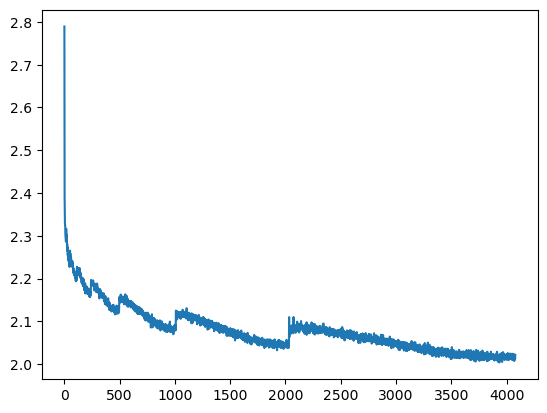

In [78]:
plt.plot(np.arange(len(Train)),Train)

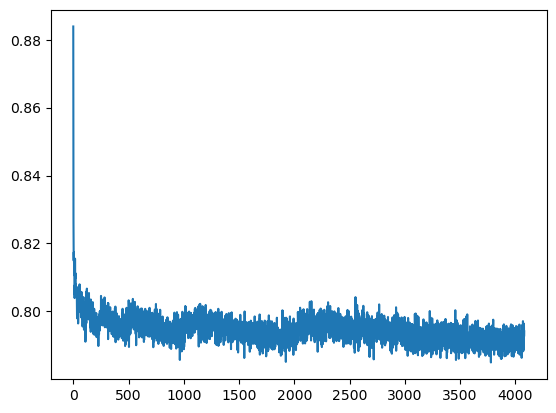

In [79]:
plt.plot(np.arange(len(Eval)),Eval)

In [80]:
fname = "models/stateATT_5L_fixed.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7220045924186707

EVALUATING ON TEST DATA : 
score_test = 0.8083394169807434

EVALUATING ON VAL DATA : 
score_val = 0.7904196381568909



In [81]:
fname = "models/stateATT_5L_fixed_best.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7225131392478943

EVALUATING ON TEST DATA : 
score_test = 0.8086221218109131

EVALUATING ON VAL DATA : 
score_val = 0.7914513945579529



In [82]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/stateATT_6L_fixed.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.806739330291748, val_loss = 0.8816468119621277
epoch n°1 : train_loss = 2.5022969245910645, val_loss = 0.8408346176147461
epoch n°2 : train_loss = 2.4001095294952393, val_loss = 0.8274690508842468
epoch n°3 : train_loss = 2.371164083480835, val_loss = 0.8199614882469177
epoch n°4 : train_loss = 2.3547325134277344, val_loss = 0.8223732709884644
epoch n°5 : train_loss = 2.3445284366607666, val_loss = 0.814386248588562
epoch n°6 : train_loss = 2.3266186714172363, val_loss = 0.8143227100372314
epoch n°7 : train_loss = 2.3193273544311523, val_loss = 0.8111643195152283
epoch n°8 : train_loss = 2.3149149417877197, val_loss = 0.8108239769935608
epoch n°9 : train_loss = 2.310821056365967, val_loss = 0.8116379976272583
epoch n°10 : train_loss = 2.301464319229126, val_loss = 0.8089765906333923
epoch n°11 : train_loss = 2.296995162963867, val_loss = 0.8098387122154236
epoch n°12 : train_loss = 2.29388165473938, val_loss = 0.8102185726165771
epoch n°13 : train_loss = 2.29

epoch n°109 : train_loss = 2.207512378692627, val_loss = 0.7980828285217285
epoch n°110 : train_loss = 2.212315320968628, val_loss = 0.7977216839790344
epoch n°111 : train_loss = 2.2042930126190186, val_loss = 0.794154942035675
epoch n°112 : train_loss = 2.2243716716766357, val_loss = 0.8006142973899841
epoch n°113 : train_loss = 2.226938009262085, val_loss = 0.7943142652511597
epoch n°114 : train_loss = 2.2291510105133057, val_loss = 0.8015153408050537
epoch n°115 : train_loss = 2.2294113636016846, val_loss = 0.800089418888092
epoch n°116 : train_loss = 2.2232460975646973, val_loss = 0.8044569492340088
epoch n°117 : train_loss = 2.2224931716918945, val_loss = 0.7947297096252441
epoch n°118 : train_loss = 2.22031831741333, val_loss = 0.8011676669120789
epoch n°119 : train_loss = 2.2267165184020996, val_loss = 0.8028435111045837
epoch n°120 : train_loss = 2.223907947540283, val_loss = 0.7994950413703918
epoch n°121 : train_loss = 2.2238309383392334, val_loss = 0.8016420006752014
epoch n

epoch n°217 : train_loss = 2.1665589809417725, val_loss = 0.7959944009780884
epoch n°218 : train_loss = 2.1718428134918213, val_loss = 0.7935855984687805
epoch n°219 : train_loss = 2.1632673740386963, val_loss = 0.7944694757461548
epoch n°220 : train_loss = 2.1655938625335693, val_loss = 0.7926751375198364
epoch n°221 : train_loss = 2.1671135425567627, val_loss = 0.7972661852836609
epoch n°222 : train_loss = 2.167555570602417, val_loss = 0.7933489680290222
epoch n°223 : train_loss = 2.163851261138916, val_loss = 0.7939926981925964
epoch n°224 : train_loss = 2.1767630577087402, val_loss = 0.7945605516433716
epoch n°225 : train_loss = 2.169572353363037, val_loss = 0.792656660079956
epoch n°226 : train_loss = 2.1701529026031494, val_loss = 0.7969812750816345
epoch n°227 : train_loss = 2.167621612548828, val_loss = 0.7936090230941772
epoch n°228 : train_loss = 2.1636319160461426, val_loss = 0.7923827767372131
epoch n°229 : train_loss = 2.17431378364563, val_loss = 0.7979716658592224
epoch 

epoch n°325 : train_loss = 2.170300245285034, val_loss = 0.7992147207260132
epoch n°326 : train_loss = 2.1665139198303223, val_loss = 0.7993298172950745
epoch n°327 : train_loss = 2.1702558994293213, val_loss = 0.7952573895454407
epoch n°328 : train_loss = 2.171250343322754, val_loss = 0.799369752407074
epoch n°329 : train_loss = 2.162463903427124, val_loss = 0.7972077131271362
epoch n°330 : train_loss = 2.169067144393921, val_loss = 0.7933105826377869
epoch n°331 : train_loss = 2.177208185195923, val_loss = 0.7969515323638916
epoch n°332 : train_loss = 2.1665377616882324, val_loss = 0.8031787276268005
epoch n°333 : train_loss = 2.1663808822631836, val_loss = 0.797497570514679
epoch n°334 : train_loss = 2.159637689590454, val_loss = 0.7976476550102234
epoch n°335 : train_loss = 2.163597583770752, val_loss = 0.7935846447944641
epoch n°336 : train_loss = 2.161052703857422, val_loss = 0.7980049848556519
epoch n°337 : train_loss = 2.156229019165039, val_loss = 0.7917993664741516
epoch n°33

epoch n°433 : train_loss = 2.126255750656128, val_loss = 0.7952192425727844
epoch n°434 : train_loss = 2.124504566192627, val_loss = 0.7943929433822632
epoch n°435 : train_loss = 2.1243550777435303, val_loss = 0.792349636554718
epoch n°436 : train_loss = 2.1276321411132812, val_loss = 0.7917258143424988
epoch n°437 : train_loss = 2.1233880519866943, val_loss = 0.794529139995575
epoch n°438 : train_loss = 2.125499725341797, val_loss = 0.7959420084953308
epoch n°439 : train_loss = 2.1214230060577393, val_loss = 0.7915503978729248
epoch n°440 : train_loss = 2.1342520713806152, val_loss = 0.7933728694915771
epoch n°441 : train_loss = 2.1298272609710693, val_loss = 0.7931636571884155
epoch n°442 : train_loss = 2.124436140060425, val_loss = 0.7894834280014038
epoch n°443 : train_loss = 2.1343398094177246, val_loss = 0.7945133447647095
epoch n°444 : train_loss = 2.1312007904052734, val_loss = 0.7940004467964172
epoch n°445 : train_loss = 2.1263930797576904, val_loss = 0.7940899729728699
epoch

epoch n°541 : train_loss = 2.143472909927368, val_loss = 0.794990599155426
epoch n°542 : train_loss = 2.148756504058838, val_loss = 0.7979754209518433
epoch n°543 : train_loss = 2.1481375694274902, val_loss = 0.7945008873939514
epoch n°544 : train_loss = 2.145817518234253, val_loss = 0.7992925643920898
epoch n°545 : train_loss = 2.1608331203460693, val_loss = 0.7967986464500427
epoch n°546 : train_loss = 2.138352632522583, val_loss = 0.7960898280143738
epoch n°547 : train_loss = 2.152390241622925, val_loss = 0.795279860496521
epoch n°548 : train_loss = 2.150275707244873, val_loss = 0.7910460829734802
epoch n°549 : train_loss = 2.1484315395355225, val_loss = 0.7969066500663757
epoch n°550 : train_loss = 2.153146982192993, val_loss = 0.7954768538475037
epoch n°551 : train_loss = 2.1528890132904053, val_loss = 0.7960150241851807
epoch n°552 : train_loss = 2.147212028503418, val_loss = 0.7978477478027344
epoch n°553 : train_loss = 2.135885000228882, val_loss = 0.7980668544769287
epoch n°55

epoch n°649 : train_loss = 2.1365599632263184, val_loss = 0.7980204820632935
epoch n°650 : train_loss = 2.13140606880188, val_loss = 0.7942866086959839
epoch n°651 : train_loss = 2.130439519882202, val_loss = 0.7953019142150879
epoch n°652 : train_loss = 2.1333091259002686, val_loss = 0.7940741777420044
epoch n°653 : train_loss = 2.133861780166626, val_loss = 0.7980040907859802
epoch n°654 : train_loss = 2.1287572383880615, val_loss = 0.7916649580001831
epoch n°655 : train_loss = 2.125403642654419, val_loss = 0.7979270815849304
epoch n°656 : train_loss = 2.1286165714263916, val_loss = 0.7909977436065674
epoch n°657 : train_loss = 2.1347336769104004, val_loss = 0.7932138442993164
epoch n°658 : train_loss = 2.117732048034668, val_loss = 0.7945458292961121
epoch n°659 : train_loss = 2.1316208839416504, val_loss = 0.7913652658462524
epoch n°660 : train_loss = 2.1274917125701904, val_loss = 0.7964085340499878
epoch n°661 : train_loss = 2.1285507678985596, val_loss = 0.7984780073165894
epoch

epoch n°757 : train_loss = 2.0992233753204346, val_loss = 0.8000769019126892
epoch n°758 : train_loss = 2.099357843399048, val_loss = 0.7932307124137878
epoch n°759 : train_loss = 2.100553035736084, val_loss = 0.7962704300880432
epoch n°760 : train_loss = 2.1014814376831055, val_loss = 0.7944208383560181
epoch n°761 : train_loss = 2.1050827503204346, val_loss = 0.7921178936958313
epoch n°762 : train_loss = 2.105966567993164, val_loss = 0.7938555479049683
epoch n°763 : train_loss = 2.1047463417053223, val_loss = 0.7954151630401611
epoch n°764 : train_loss = 2.1025426387786865, val_loss = 0.791235089302063
epoch n°765 : train_loss = 2.111398220062256, val_loss = 0.7937304973602295
epoch n°766 : train_loss = 2.10072922706604, val_loss = 0.7945005893707275
epoch n°767 : train_loss = 2.113544225692749, val_loss = 0.7928482294082642
epoch n°768 : train_loss = 2.115508794784546, val_loss = 0.7935711741447449
epoch n°769 : train_loss = 2.094050884246826, val_loss = 0.7983036637306213
epoch n°7

epoch n°865 : train_loss = 2.0857269763946533, val_loss = 0.7921951413154602
epoch n°866 : train_loss = 2.0852160453796387, val_loss = 0.7959306836128235
epoch n°867 : train_loss = 2.088175058364868, val_loss = 0.7957115173339844
epoch n°868 : train_loss = 2.0881471633911133, val_loss = 0.787458598613739
epoch n°869 : train_loss = 2.084498405456543, val_loss = 0.7901675701141357
epoch n°870 : train_loss = 2.087707042694092, val_loss = 0.7939946055412292
epoch n°871 : train_loss = 2.088046073913574, val_loss = 0.7913609147071838
epoch n°872 : train_loss = 2.087049722671509, val_loss = 0.7888826727867126
epoch n°873 : train_loss = 2.0899100303649902, val_loss = 0.7943175435066223
epoch n°874 : train_loss = 2.0961880683898926, val_loss = 0.7988506555557251
epoch n°875 : train_loss = 2.0943667888641357, val_loss = 0.7928240299224854
epoch n°876 : train_loss = 2.0890684127807617, val_loss = 0.794592022895813
epoch n°877 : train_loss = 2.0822246074676514, val_loss = 0.7964931130409241
epoch 

epoch n°973 : train_loss = 2.087625741958618, val_loss = 0.7923905849456787
epoch n°974 : train_loss = 2.0830795764923096, val_loss = 0.7890609502792358
epoch n°975 : train_loss = 2.0800702571868896, val_loss = 0.7991507053375244
epoch n°976 : train_loss = 2.0892956256866455, val_loss = 0.7905445098876953
epoch n°977 : train_loss = 2.081784963607788, val_loss = 0.7919243574142456
epoch n°978 : train_loss = 2.0868911743164062, val_loss = 0.7914376258850098
epoch n°979 : train_loss = 2.089404821395874, val_loss = 0.7941518425941467
epoch n°980 : train_loss = 2.0824899673461914, val_loss = 0.7976041436195374
epoch n°981 : train_loss = 2.078298568725586, val_loss = 0.7936816811561584
epoch n°982 : train_loss = 2.0823965072631836, val_loss = 0.7918061017990112
epoch n°983 : train_loss = 2.0838375091552734, val_loss = 0.788535475730896
epoch n°984 : train_loss = 2.0886270999908447, val_loss = 0.7897277474403381
epoch n°985 : train_loss = 2.0866270065307617, val_loss = 0.7917271852493286
epoc

epoch n°1080 : train_loss = 2.1104772090911865, val_loss = 0.7965884804725647
epoch n°1081 : train_loss = 2.1107892990112305, val_loss = 0.7940019965171814
epoch n°1082 : train_loss = 2.117974042892456, val_loss = 0.7967818379402161
epoch n°1083 : train_loss = 2.1215715408325195, val_loss = 0.7988618612289429
epoch n°1084 : train_loss = 2.1095328330993652, val_loss = 0.7989643812179565
epoch n°1085 : train_loss = 2.1154208183288574, val_loss = 0.7994586229324341
epoch n°1086 : train_loss = 2.111900806427002, val_loss = 0.7984288930892944
epoch n°1087 : train_loss = 2.11476993560791, val_loss = 0.7978559136390686
epoch n°1088 : train_loss = 2.1061012744903564, val_loss = 0.7969882488250732
epoch n°1089 : train_loss = 2.1151845455169678, val_loss = 0.793915331363678
epoch n°1090 : train_loss = 2.106168746948242, val_loss = 0.7958977818489075
epoch n°1091 : train_loss = 2.111713409423828, val_loss = 0.7946356534957886
epoch n°1092 : train_loss = 2.1152963638305664, val_loss = 0.7970262169

epoch n°1186 : train_loss = 2.1086513996124268, val_loss = 0.8022571802139282
epoch n°1187 : train_loss = 2.0960116386413574, val_loss = 0.7985963821411133
epoch n°1188 : train_loss = 2.1148111820220947, val_loss = 0.7974452972412109
epoch n°1189 : train_loss = 2.119025707244873, val_loss = 0.7942862510681152
epoch n°1190 : train_loss = 2.113572597503662, val_loss = 0.7978433966636658
epoch n°1191 : train_loss = 2.1043710708618164, val_loss = 0.7906767129898071
epoch n°1192 : train_loss = 2.1071488857269287, val_loss = 0.7972725629806519
epoch n°1193 : train_loss = 2.105257749557495, val_loss = 0.7953662276268005
epoch n°1194 : train_loss = 2.1063015460968018, val_loss = 0.7912688255310059
epoch n°1195 : train_loss = 2.1030433177948, val_loss = 0.7983973622322083
epoch n°1196 : train_loss = 2.104412317276001, val_loss = 0.7987870573997498
epoch n°1197 : train_loss = 2.1157138347625732, val_loss = 0.7957521080970764
epoch n°1198 : train_loss = 2.097208261489868, val_loss = 0.79867208003

epoch n°1292 : train_loss = 2.094172477722168, val_loss = 0.7985141277313232
epoch n°1293 : train_loss = 2.0933516025543213, val_loss = 0.7977502346038818
epoch n°1294 : train_loss = 2.1007018089294434, val_loss = 0.794395387172699
epoch n°1295 : train_loss = 2.0929956436157227, val_loss = 0.7975473999977112
epoch n°1296 : train_loss = 2.0942013263702393, val_loss = 0.7967666983604431
epoch n°1297 : train_loss = 2.096698760986328, val_loss = 0.7946879267692566
epoch n°1298 : train_loss = 2.100573778152466, val_loss = 0.7943485975265503
epoch n°1299 : train_loss = 2.093378782272339, val_loss = 0.8001096844673157
epoch n°1300 : train_loss = 2.0911552906036377, val_loss = 0.7964851260185242
epoch n°1301 : train_loss = 2.091792106628418, val_loss = 0.7971223592758179
epoch n°1302 : train_loss = 2.088502883911133, val_loss = 0.7977346181869507
epoch n°1303 : train_loss = 2.090897560119629, val_loss = 0.7967677116394043
epoch n°1304 : train_loss = 2.1004791259765625, val_loss = 0.79549306631

epoch n°1398 : train_loss = 2.0802416801452637, val_loss = 0.7974389791488647
epoch n°1399 : train_loss = 2.0815093517303467, val_loss = 0.7923377156257629
epoch n°1400 : train_loss = 2.0791757106781006, val_loss = 0.7998242378234863
epoch n°1401 : train_loss = 2.0903265476226807, val_loss = 0.793652355670929
epoch n°1402 : train_loss = 2.0875887870788574, val_loss = 0.7955126166343689
epoch n°1403 : train_loss = 2.077693462371826, val_loss = 0.7986419200897217
epoch n°1404 : train_loss = 2.0858426094055176, val_loss = 0.7979470491409302
epoch n°1405 : train_loss = 2.085702896118164, val_loss = 0.7944110631942749
epoch n°1406 : train_loss = 2.081789493560791, val_loss = 0.7964059114456177
epoch n°1407 : train_loss = 2.0814781188964844, val_loss = 0.79310542345047
epoch n°1408 : train_loss = 2.0844178199768066, val_loss = 0.790240466594696
epoch n°1409 : train_loss = 2.082747220993042, val_loss = 0.7974585294723511
epoch n°1410 : train_loss = 2.085602283477783, val_loss = 0.793652176856

epoch n°1504 : train_loss = 2.073406934738159, val_loss = 0.7958030104637146
epoch n°1505 : train_loss = 2.0681416988372803, val_loss = 0.7938876748085022
epoch n°1506 : train_loss = 2.0815300941467285, val_loss = 0.7958853244781494
epoch n°1507 : train_loss = 2.0715463161468506, val_loss = 0.7921621203422546
epoch n°1508 : train_loss = 2.074373722076416, val_loss = 0.7926411628723145
epoch n°1509 : train_loss = 2.072723627090454, val_loss = 0.7919037938117981
epoch n°1510 : train_loss = 2.065016746520996, val_loss = 0.7906702756881714
epoch n°1511 : train_loss = 2.077275037765503, val_loss = 0.7977227568626404
epoch n°1512 : train_loss = 2.0755465030670166, val_loss = 0.7902873754501343
epoch n°1513 : train_loss = 2.072005033493042, val_loss = 0.7944962978363037
epoch n°1514 : train_loss = 2.072032928466797, val_loss = 0.7948098182678223
epoch n°1515 : train_loss = 2.0705628395080566, val_loss = 0.795509934425354
epoch n°1516 : train_loss = 2.0759854316711426, val_loss = 0.79086321592

epoch n°1610 : train_loss = 2.067066192626953, val_loss = 0.7940394282341003
epoch n°1611 : train_loss = 2.065549612045288, val_loss = 0.7958130836486816
epoch n°1612 : train_loss = 2.0522186756134033, val_loss = 0.7917007207870483
epoch n°1613 : train_loss = 2.0647568702697754, val_loss = 0.7950882315635681
epoch n°1614 : train_loss = 2.0643255710601807, val_loss = 0.7963700294494629
epoch n°1615 : train_loss = 2.0663628578186035, val_loss = 0.7972254753112793
epoch n°1616 : train_loss = 2.068795919418335, val_loss = 0.7938092350959778
epoch n°1617 : train_loss = 2.0684401988983154, val_loss = 0.7942777872085571
epoch n°1618 : train_loss = 2.0667569637298584, val_loss = 0.7930254340171814
epoch n°1619 : train_loss = 2.068998098373413, val_loss = 0.7956603169441223
epoch n°1620 : train_loss = 2.0627503395080566, val_loss = 0.7906712889671326
epoch n°1621 : train_loss = 2.066612958908081, val_loss = 0.795521080493927
epoch n°1622 : train_loss = 2.0565249919891357, val_loss = 0.796003878

epoch n°1716 : train_loss = 2.0528690814971924, val_loss = 0.7929670214653015
epoch n°1717 : train_loss = 2.0531373023986816, val_loss = 0.7962546944618225
epoch n°1718 : train_loss = 2.0531749725341797, val_loss = 0.7914204001426697
epoch n°1719 : train_loss = 2.0516304969787598, val_loss = 0.7919653058052063
epoch n°1720 : train_loss = 2.0607030391693115, val_loss = 0.7917218804359436
epoch n°1721 : train_loss = 2.0567119121551514, val_loss = 0.7906481027603149
epoch n°1722 : train_loss = 2.057494640350342, val_loss = 0.789695680141449
epoch n°1723 : train_loss = 2.059636354446411, val_loss = 0.7973007559776306
epoch n°1724 : train_loss = 2.060004234313965, val_loss = 0.7925360798835754
epoch n°1725 : train_loss = 2.0586307048797607, val_loss = 0.7886516451835632
epoch n°1726 : train_loss = 2.053795337677002, val_loss = 0.7884158492088318
epoch n°1727 : train_loss = 2.0498580932617188, val_loss = 0.7939173579216003
epoch n°1728 : train_loss = 2.063645362854004, val_loss = 0.792803585

epoch n°1822 : train_loss = 2.0476293563842773, val_loss = 0.7885520458221436
epoch n°1823 : train_loss = 2.0516746044158936, val_loss = 0.7942059636116028
epoch n°1824 : train_loss = 2.0487325191497803, val_loss = 0.7900503277778625
epoch n°1825 : train_loss = 2.052325487136841, val_loss = 0.7936899662017822
epoch n°1826 : train_loss = 2.055264711380005, val_loss = 0.7869281768798828
epoch n°1827 : train_loss = 2.0501227378845215, val_loss = 0.7898303270339966
epoch n°1828 : train_loss = 2.047653913497925, val_loss = 0.7914480566978455
epoch n°1829 : train_loss = 2.057260751724243, val_loss = 0.7927433848381042
epoch n°1830 : train_loss = 2.0544066429138184, val_loss = 0.7965286374092102
epoch n°1831 : train_loss = 2.0458996295928955, val_loss = 0.7923217415809631
epoch n°1832 : train_loss = 2.0513839721679688, val_loss = 0.7894191145896912
epoch n°1833 : train_loss = 2.049201488494873, val_loss = 0.7896466851234436
epoch n°1834 : train_loss = 2.0476958751678467, val_loss = 0.79047125

epoch n°1928 : train_loss = 2.0425162315368652, val_loss = 0.7912387847900391
epoch n°1929 : train_loss = 2.055044651031494, val_loss = 0.791564404964447
epoch n°1930 : train_loss = 2.0475363731384277, val_loss = 0.7928693890571594
epoch n°1931 : train_loss = 2.05267071723938, val_loss = 0.7918727993965149
epoch n°1932 : train_loss = 2.0410211086273193, val_loss = 0.7937671542167664
epoch n°1933 : train_loss = 2.0422303676605225, val_loss = 0.7919063568115234
epoch n°1934 : train_loss = 2.051815986633301, val_loss = 0.7911953926086426
epoch n°1935 : train_loss = 2.0521509647369385, val_loss = 0.7905537486076355
epoch n°1936 : train_loss = 2.0535318851470947, val_loss = 0.7937097549438477
epoch n°1937 : train_loss = 2.045029640197754, val_loss = 0.7933563590049744
epoch n°1938 : train_loss = 2.046346664428711, val_loss = 0.7908198237419128
epoch n°1939 : train_loss = 2.0501129627227783, val_loss = 0.7929078936576843
epoch n°1940 : train_loss = 2.0452489852905273, val_loss = 0.7936273813

epoch n°2034 : train_loss = 2.0830535888671875, val_loss = 0.794701337814331
epoch n°2035 : train_loss = 2.069838047027588, val_loss = 0.797335147857666
epoch n°2036 : train_loss = 2.086618661880493, val_loss = 0.7954832911491394
epoch n°2037 : train_loss = 2.0721187591552734, val_loss = 0.7940311431884766
epoch n°2038 : train_loss = 2.0729782581329346, val_loss = 0.7962014079093933
epoch n°2039 : train_loss = 2.072737693786621, val_loss = 0.7986769080162048
epoch n°2040 : train_loss = 2.0771169662475586, val_loss = 0.7974206805229187
epoch n°2041 : train_loss = 2.0775604248046875, val_loss = 0.8007815480232239
epoch n°2042 : train_loss = 2.0865635871887207, val_loss = 0.7966481447219849
epoch n°2043 : train_loss = 2.080552577972412, val_loss = 0.8001405000686646
epoch n°2044 : train_loss = 2.0748941898345947, val_loss = 0.7955760359764099
epoch n°2045 : train_loss = 2.0787360668182373, val_loss = 0.7938288450241089
epoch n°2046 : train_loss = 2.0710248947143555, val_loss = 0.793052673

epoch n°2140 : train_loss = 2.084346055984497, val_loss = 0.7936672568321228
epoch n°2141 : train_loss = 2.079902172088623, val_loss = 0.7992623448371887
epoch n°2142 : train_loss = 2.0900702476501465, val_loss = 0.7967392206192017
epoch n°2143 : train_loss = 2.0887112617492676, val_loss = 0.7935173511505127
epoch n°2144 : train_loss = 2.0972702503204346, val_loss = 0.7970023155212402
epoch n°2145 : train_loss = 2.090153217315674, val_loss = 0.7995020747184753
epoch n°2146 : train_loss = 2.085897922515869, val_loss = 0.7957119941711426
epoch n°2147 : train_loss = 2.078033447265625, val_loss = 0.7964492440223694
epoch n°2148 : train_loss = 2.0816550254821777, val_loss = 0.7976094484329224
epoch n°2149 : train_loss = 2.0785582065582275, val_loss = 0.7965735197067261
epoch n°2150 : train_loss = 2.087175130844116, val_loss = 0.7993032336235046
epoch n°2151 : train_loss = 2.080585241317749, val_loss = 0.7974944710731506
epoch n°2152 : train_loss = 2.0889532566070557, val_loss = 0.7954165339

epoch n°2246 : train_loss = 2.0897886753082275, val_loss = 0.7949420213699341
epoch n°2247 : train_loss = 2.0879743099212646, val_loss = 0.7964387536048889
epoch n°2248 : train_loss = 2.0821032524108887, val_loss = 0.7921889424324036
epoch n°2249 : train_loss = 2.085263967514038, val_loss = 0.7922530174255371
epoch n°2250 : train_loss = 2.0802135467529297, val_loss = 0.7968684434890747
epoch n°2251 : train_loss = 2.0886459350585938, val_loss = 0.799882173538208
epoch n°2252 : train_loss = 2.0898914337158203, val_loss = 0.7933930158615112
epoch n°2253 : train_loss = 2.076796054840088, val_loss = 0.7957336902618408
epoch n°2254 : train_loss = 2.0784711837768555, val_loss = 0.7937808632850647
epoch n°2255 : train_loss = 2.076357364654541, val_loss = 0.7946049571037292
epoch n°2256 : train_loss = 2.0795328617095947, val_loss = 0.7994171380996704
epoch n°2257 : train_loss = 2.0834689140319824, val_loss = 0.7987583875656128
epoch n°2258 : train_loss = 2.081749200820923, val_loss = 0.79266142

epoch n°2352 : train_loss = 2.075806140899658, val_loss = 0.7946057319641113
epoch n°2353 : train_loss = 2.0794730186462402, val_loss = 0.795504093170166
epoch n°2354 : train_loss = 2.0754482746124268, val_loss = 0.7976140975952148
epoch n°2355 : train_loss = 2.0761001110076904, val_loss = 0.7981002330780029
epoch n°2356 : train_loss = 2.0840656757354736, val_loss = 0.7962779998779297
epoch n°2357 : train_loss = 2.0833685398101807, val_loss = 0.7972710728645325
epoch n°2358 : train_loss = 2.089900016784668, val_loss = 0.792864203453064
epoch n°2359 : train_loss = 2.0820794105529785, val_loss = 0.7920889258384705
epoch n°2360 : train_loss = 2.068296194076538, val_loss = 0.7956326007843018
epoch n°2361 : train_loss = 2.0719614028930664, val_loss = 0.7971944808959961
epoch n°2362 : train_loss = 2.0719563961029053, val_loss = 0.7956191897392273
epoch n°2363 : train_loss = 2.0804519653320312, val_loss = 0.796035885810852
epoch n°2364 : train_loss = 2.0694923400878906, val_loss = 0.795520603

epoch n°2458 : train_loss = 2.0761380195617676, val_loss = 0.7924602627754211
epoch n°2459 : train_loss = 2.066833019256592, val_loss = 0.7969042658805847
epoch n°2460 : train_loss = 2.075873851776123, val_loss = 0.7993742227554321
epoch n°2461 : train_loss = 2.079108715057373, val_loss = 0.7976351976394653
epoch n°2462 : train_loss = 2.064790725708008, val_loss = 0.7890793681144714
epoch n°2463 : train_loss = 2.074547052383423, val_loss = 0.7956620454788208
epoch n°2464 : train_loss = 2.0754830837249756, val_loss = 0.794634997844696
epoch n°2465 : train_loss = 2.0771164894104004, val_loss = 0.7902213335037231
epoch n°2466 : train_loss = 2.08648681640625, val_loss = 0.794048547744751
epoch n°2467 : train_loss = 2.0615360736846924, val_loss = 0.7948229908943176
epoch n°2468 : train_loss = 2.07049822807312, val_loss = 0.7961206436157227
epoch n°2469 : train_loss = 2.0683064460754395, val_loss = 0.7928538918495178
epoch n°2470 : train_loss = 2.0835211277008057, val_loss = 0.79313391447067

epoch n°2564 : train_loss = 2.080104351043701, val_loss = 0.7970274090766907
epoch n°2565 : train_loss = 2.0702080726623535, val_loss = 0.7948424220085144
epoch n°2566 : train_loss = 2.0659167766571045, val_loss = 0.7979874014854431
epoch n°2567 : train_loss = 2.06240177154541, val_loss = 0.7958927154541016
epoch n°2568 : train_loss = 2.066502332687378, val_loss = 0.7954502105712891
epoch n°2569 : train_loss = 2.0689918994903564, val_loss = 0.7977456450462341
epoch n°2570 : train_loss = 2.0666213035583496, val_loss = 0.7955062389373779
epoch n°2571 : train_loss = 2.069141149520874, val_loss = 0.7962725162506104
epoch n°2572 : train_loss = 2.063840627670288, val_loss = 0.7952845096588135
epoch n°2573 : train_loss = 2.074042320251465, val_loss = 0.7944539785385132
epoch n°2574 : train_loss = 2.068006992340088, val_loss = 0.7906416058540344
epoch n°2575 : train_loss = 2.067474603652954, val_loss = 0.7915813326835632
epoch n°2576 : train_loss = 2.0699462890625, val_loss = 0.793806672096252

epoch n°2670 : train_loss = 2.0649633407592773, val_loss = 0.7933745384216309
epoch n°2671 : train_loss = 2.066453695297241, val_loss = 0.797985851764679
epoch n°2672 : train_loss = 2.0578935146331787, val_loss = 0.7947227954864502
epoch n°2673 : train_loss = 2.064446210861206, val_loss = 0.8007156252861023
epoch n°2674 : train_loss = 2.066132068634033, val_loss = 0.7959911227226257
epoch n°2675 : train_loss = 2.0668256282806396, val_loss = 0.7964301109313965
epoch n°2676 : train_loss = 2.0652828216552734, val_loss = 0.7916955947875977
epoch n°2677 : train_loss = 2.064474105834961, val_loss = 0.7902123928070068
epoch n°2678 : train_loss = 2.0657882690429688, val_loss = 0.795642077922821
epoch n°2679 : train_loss = 2.0729804039001465, val_loss = 0.7931274175643921
epoch n°2680 : train_loss = 2.0576000213623047, val_loss = 0.7980756163597107
epoch n°2681 : train_loss = 2.0635111331939697, val_loss = 0.7944830656051636
epoch n°2682 : train_loss = 2.0695137977600098, val_loss = 0.793146669

epoch n°2776 : train_loss = 2.061394214630127, val_loss = 0.7932475805282593
epoch n°2777 : train_loss = 2.0600383281707764, val_loss = 0.7960668206214905
epoch n°2778 : train_loss = 2.052992343902588, val_loss = 0.7963016033172607
epoch n°2779 : train_loss = 2.060129404067993, val_loss = 0.7997118234634399
epoch n°2780 : train_loss = 2.062008857727051, val_loss = 0.7913984060287476
epoch n°2781 : train_loss = 2.0568935871124268, val_loss = 0.7923591136932373
epoch n°2782 : train_loss = 2.0638515949249268, val_loss = 0.7959922552108765
epoch n°2783 : train_loss = 2.0645594596862793, val_loss = 0.7981419563293457
epoch n°2784 : train_loss = 2.05869197845459, val_loss = 0.7935437560081482
epoch n°2785 : train_loss = 2.060377597808838, val_loss = 0.7947568297386169
epoch n°2786 : train_loss = 2.055619955062866, val_loss = 0.7974889874458313
epoch n°2787 : train_loss = 2.0567567348480225, val_loss = 0.7929900288581848
epoch n°2788 : train_loss = 2.057819128036499, val_loss = 0.791736543178

epoch n°2883 : train_loss = 2.050869941711426, val_loss = 0.794858455657959
epoch n°2884 : train_loss = 2.054370880126953, val_loss = 0.7964816093444824
epoch n°2885 : train_loss = 2.0576937198638916, val_loss = 0.7909227609634399
epoch n°2886 : train_loss = 2.053743362426758, val_loss = 0.7935798168182373
epoch n°2887 : train_loss = 2.056135654449463, val_loss = 0.7964557409286499
epoch n°2888 : train_loss = 2.043368101119995, val_loss = 0.7923924326896667
epoch n°2889 : train_loss = 2.052386522293091, val_loss = 0.7913411259651184
epoch n°2890 : train_loss = 2.049285888671875, val_loss = 0.7951844930648804
epoch n°2891 : train_loss = 2.059156656265259, val_loss = 0.7923597693443298
epoch n°2892 : train_loss = 2.059976100921631, val_loss = 0.7953454256057739
epoch n°2893 : train_loss = 2.0559849739074707, val_loss = 0.7928661108016968
epoch n°2894 : train_loss = 2.055562973022461, val_loss = 0.7927262187004089
epoch n°2895 : train_loss = 2.0513744354248047, val_loss = 0.79423797130584

epoch n°2989 : train_loss = 2.049650192260742, val_loss = 0.7912436723709106
epoch n°2990 : train_loss = 2.050290107727051, val_loss = 0.7922056317329407
epoch n°2991 : train_loss = 2.0521113872528076, val_loss = 0.7951812148094177
epoch n°2992 : train_loss = 2.0495948791503906, val_loss = 0.7946453094482422
epoch n°2993 : train_loss = 2.0444915294647217, val_loss = 0.7965961694717407
epoch n°2994 : train_loss = 2.0487186908721924, val_loss = 0.7936671376228333
epoch n°2995 : train_loss = 2.04487943649292, val_loss = 0.7945451140403748
epoch n°2996 : train_loss = 2.0526363849639893, val_loss = 0.7920135855674744
epoch n°2997 : train_loss = 2.0441839694976807, val_loss = 0.7936134934425354
epoch n°2998 : train_loss = 2.04767107963562, val_loss = 0.7921671271324158
epoch n°2999 : train_loss = 2.0526349544525146, val_loss = 0.7939581274986267
epoch n°3000 : train_loss = 2.0418624877929688, val_loss = 0.7930604815483093
epoch n°3001 : train_loss = 2.0453758239746094, val_loss = 0.796531736

epoch n°3095 : train_loss = 2.03889799118042, val_loss = 0.7914630174636841
epoch n°3096 : train_loss = 2.0389819145202637, val_loss = 0.7933796048164368
epoch n°3097 : train_loss = 2.0475990772247314, val_loss = 0.7963065505027771
epoch n°3098 : train_loss = 2.0443716049194336, val_loss = 0.7920445203781128
epoch n°3099 : train_loss = 2.0390658378601074, val_loss = 0.7927496433258057
epoch n°3100 : train_loss = 2.0518393516540527, val_loss = 0.7942494750022888
epoch n°3101 : train_loss = 2.0357470512390137, val_loss = 0.7914257049560547
epoch n°3102 : train_loss = 2.041677474975586, val_loss = 0.7923133969306946
epoch n°3103 : train_loss = 2.0325756072998047, val_loss = 0.7942034006118774
epoch n°3104 : train_loss = 2.035407304763794, val_loss = 0.7960848808288574
epoch n°3105 : train_loss = 2.0407238006591797, val_loss = 0.7916898727416992
epoch n°3106 : train_loss = 2.046086549758911, val_loss = 0.7928257584571838
epoch n°3107 : train_loss = 2.0353634357452393, val_loss = 0.79329872

epoch n°3201 : train_loss = 2.0430221557617188, val_loss = 0.7984341979026794
epoch n°3202 : train_loss = 2.042081356048584, val_loss = 0.7874875664710999
epoch n°3203 : train_loss = 2.0364367961883545, val_loss = 0.7912449240684509
epoch n°3204 : train_loss = 2.0388309955596924, val_loss = 0.7941177487373352
epoch n°3205 : train_loss = 2.0346646308898926, val_loss = 0.7923726439476013
epoch n°3206 : train_loss = 2.038255214691162, val_loss = 0.7923747301101685
epoch n°3207 : train_loss = 2.034355640411377, val_loss = 0.7942266464233398
epoch n°3208 : train_loss = 2.032715320587158, val_loss = 0.7953342199325562
epoch n°3209 : train_loss = 2.040722131729126, val_loss = 0.795613706111908
epoch n°3210 : train_loss = 2.0363194942474365, val_loss = 0.7964946627616882
epoch n°3211 : train_loss = 2.0426383018493652, val_loss = 0.7891143560409546
epoch n°3212 : train_loss = 2.0337421894073486, val_loss = 0.7935155630111694
epoch n°3213 : train_loss = 2.0477676391601562, val_loss = 0.792205035

epoch n°3307 : train_loss = 2.029017686843872, val_loss = 0.7912734150886536
epoch n°3308 : train_loss = 2.0292420387268066, val_loss = 0.7945892810821533
epoch n°3309 : train_loss = 2.024249792098999, val_loss = 0.7924929261207581
epoch n°3310 : train_loss = 2.0263917446136475, val_loss = 0.7917742729187012
epoch n°3311 : train_loss = 2.0367870330810547, val_loss = 0.7949346303939819
epoch n°3312 : train_loss = 2.03702974319458, val_loss = 0.7874361276626587
epoch n°3313 : train_loss = 2.0350341796875, val_loss = 0.7918745279312134
epoch n°3314 : train_loss = 2.0343356132507324, val_loss = 0.7907124757766724
epoch n°3315 : train_loss = 2.030606269836426, val_loss = 0.7918067574501038
epoch n°3316 : train_loss = 2.0293564796447754, val_loss = 0.7912185788154602
epoch n°3317 : train_loss = 2.032087802886963, val_loss = 0.792349100112915
epoch n°3318 : train_loss = 2.032881498336792, val_loss = 0.792455792427063
epoch n°3319 : train_loss = 2.0312297344207764, val_loss = 0.793173849582672

epoch n°3413 : train_loss = 2.0338501930236816, val_loss = 0.7925199270248413
epoch n°3414 : train_loss = 2.0329220294952393, val_loss = 0.7900111675262451
epoch n°3415 : train_loss = 2.033552646636963, val_loss = 0.7935681343078613
epoch n°3416 : train_loss = 2.029850721359253, val_loss = 0.7903528809547424
epoch n°3417 : train_loss = 2.0324344635009766, val_loss = 0.7979212999343872
epoch n°3418 : train_loss = 2.026163339614868, val_loss = 0.7877604365348816
epoch n°3419 : train_loss = 2.0288047790527344, val_loss = 0.7920109629631042
epoch n°3420 : train_loss = 2.025299310684204, val_loss = 0.7910645604133606
epoch n°3421 : train_loss = 2.0329487323760986, val_loss = 0.7938616871833801
epoch n°3422 : train_loss = 2.0304391384124756, val_loss = 0.7930106520652771
epoch n°3423 : train_loss = 2.028888463973999, val_loss = 0.7934586405754089
epoch n°3424 : train_loss = 2.0329673290252686, val_loss = 0.7916716933250427
epoch n°3425 : train_loss = 2.0242865085601807, val_loss = 0.79344242

epoch n°3519 : train_loss = 2.025848388671875, val_loss = 0.7928685545921326
epoch n°3520 : train_loss = 2.0218029022216797, val_loss = 0.7898856997489929
epoch n°3521 : train_loss = 2.0165350437164307, val_loss = 0.7923181653022766
epoch n°3522 : train_loss = 2.033024787902832, val_loss = 0.790270209312439
epoch n°3523 : train_loss = 2.0227317810058594, val_loss = 0.7946923971176147
epoch n°3524 : train_loss = 2.020996332168579, val_loss = 0.791409969329834
epoch n°3525 : train_loss = 2.0228419303894043, val_loss = 0.7933187484741211
epoch n°3526 : train_loss = 2.029761791229248, val_loss = 0.794736385345459
epoch n°3527 : train_loss = 2.028942108154297, val_loss = 0.7913132905960083
epoch n°3528 : train_loss = 2.022890329360962, val_loss = 0.7939503788948059
epoch n°3529 : train_loss = 2.022724151611328, val_loss = 0.7966133952140808
epoch n°3530 : train_loss = 2.035919666290283, val_loss = 0.7920951843261719
epoch n°3531 : train_loss = 2.0210533142089844, val_loss = 0.79072904586791

epoch n°3625 : train_loss = 2.023667812347412, val_loss = 0.7925688028335571
epoch n°3626 : train_loss = 2.023810386657715, val_loss = 0.7897059917449951
epoch n°3627 : train_loss = 2.0209944248199463, val_loss = 0.7899292707443237
epoch n°3628 : train_loss = 2.0331673622131348, val_loss = 0.7908260822296143
epoch n°3629 : train_loss = 2.02471661567688, val_loss = 0.7919877767562866
epoch n°3630 : train_loss = 2.0270798206329346, val_loss = 0.7929365634918213
epoch n°3631 : train_loss = 2.027400255203247, val_loss = 0.7872515320777893
epoch n°3632 : train_loss = 2.022260904312134, val_loss = 0.7885178327560425
epoch n°3633 : train_loss = 2.024932861328125, val_loss = 0.7889397740364075
epoch n°3634 : train_loss = 2.0281050205230713, val_loss = 0.7912409901618958
epoch n°3635 : train_loss = 2.027357816696167, val_loss = 0.7883908152580261
epoch n°3636 : train_loss = 2.0219779014587402, val_loss = 0.7891734838485718
epoch n°3637 : train_loss = 2.023719072341919, val_loss = 0.787682473659

epoch n°3731 : train_loss = 2.014434337615967, val_loss = 0.7908327579498291
epoch n°3732 : train_loss = 2.0156264305114746, val_loss = 0.7921072840690613
epoch n°3733 : train_loss = 2.0179977416992188, val_loss = 0.7923351526260376
epoch n°3734 : train_loss = 2.0170705318450928, val_loss = 0.7974264025688171
epoch n°3735 : train_loss = 2.030379295349121, val_loss = 0.7918828129768372
epoch n°3736 : train_loss = 2.0181801319122314, val_loss = 0.7939960956573486
epoch n°3737 : train_loss = 2.0298900604248047, val_loss = 0.7933679819107056
epoch n°3738 : train_loss = 2.0277669429779053, val_loss = 0.7863484025001526
epoch n°3739 : train_loss = 2.023834228515625, val_loss = 0.7893823981285095
epoch n°3740 : train_loss = 2.019606828689575, val_loss = 0.7892364263534546
epoch n°3741 : train_loss = 2.020435094833374, val_loss = 0.7930689454078674
epoch n°3742 : train_loss = 2.0236191749572754, val_loss = 0.7929866313934326
epoch n°3743 : train_loss = 2.016726016998291, val_loss = 0.791456341

epoch n°3837 : train_loss = 2.022946357727051, val_loss = 0.7927790284156799
epoch n°3838 : train_loss = 2.015068769454956, val_loss = 0.7936939001083374
epoch n°3839 : train_loss = 2.018878221511841, val_loss = 0.7909035086631775
epoch n°3840 : train_loss = 2.023221492767334, val_loss = 0.787031888961792
epoch n°3841 : train_loss = 2.020254373550415, val_loss = 0.7940657734870911
epoch n°3842 : train_loss = 2.0179495811462402, val_loss = 0.7904491424560547
epoch n°3843 : train_loss = 2.0142486095428467, val_loss = 0.7965977191925049
epoch n°3844 : train_loss = 2.0090065002441406, val_loss = 0.7889878749847412
epoch n°3845 : train_loss = 2.0179452896118164, val_loss = 0.7922489047050476
epoch n°3846 : train_loss = 2.02412486076355, val_loss = 0.7944772243499756
epoch n°3847 : train_loss = 2.0139787197113037, val_loss = 0.7919553518295288
epoch n°3848 : train_loss = 2.029695749282837, val_loss = 0.7929470539093018
epoch n°3849 : train_loss = 2.0165047645568848, val_loss = 0.795994102954

epoch n°3943 : train_loss = 2.0193517208099365, val_loss = 0.7954893112182617
epoch n°3944 : train_loss = 2.020547866821289, val_loss = 0.7942403554916382
epoch n°3945 : train_loss = 2.0221574306488037, val_loss = 0.7917677760124207
epoch n°3946 : train_loss = 2.0169425010681152, val_loss = 0.7896422147750854
epoch n°3947 : train_loss = 2.023258924484253, val_loss = 0.7901322841644287
epoch n°3948 : train_loss = 2.0155625343322754, val_loss = 0.7886518836021423
epoch n°3949 : train_loss = 2.0203323364257812, val_loss = 0.7935002446174622
epoch n°3950 : train_loss = 2.013791561126709, val_loss = 0.7883797287940979
epoch n°3951 : train_loss = 2.0218584537506104, val_loss = 0.7914360165596008
epoch n°3952 : train_loss = 2.025477647781372, val_loss = 0.7892099618911743
epoch n°3953 : train_loss = 2.0185446739196777, val_loss = 0.7968189120292664
epoch n°3954 : train_loss = 2.017169713973999, val_loss = 0.7939343452453613
epoch n°3955 : train_loss = 2.0150599479675293, val_loss = 0.79339897

epoch n°4049 : train_loss = 2.0156242847442627, val_loss = 0.7878194451332092
epoch n°4050 : train_loss = 2.0151820182800293, val_loss = 0.7916815280914307
epoch n°4051 : train_loss = 2.0238239765167236, val_loss = 0.7924900054931641
epoch n°4052 : train_loss = 2.016989231109619, val_loss = 0.7932640314102173
epoch n°4053 : train_loss = 2.020737648010254, val_loss = 0.7954919934272766
epoch n°4054 : train_loss = 2.0162720680236816, val_loss = 0.7935669422149658
epoch n°4055 : train_loss = 2.0123300552368164, val_loss = 0.7920802235603333
epoch n°4056 : train_loss = 2.015678644180298, val_loss = 0.7959753274917603
epoch n°4057 : train_loss = 2.0134243965148926, val_loss = 0.7899112701416016
epoch n°4058 : train_loss = 2.013160228729248, val_loss = 0.7925094962120056
epoch n°4059 : train_loss = 2.0184097290039062, val_loss = 0.7937132120132446
epoch n°4060 : train_loss = 2.018641710281372, val_loss = 0.7893060445785522
epoch n°4061 : train_loss = 2.0188405513763428, val_loss = 0.78964626

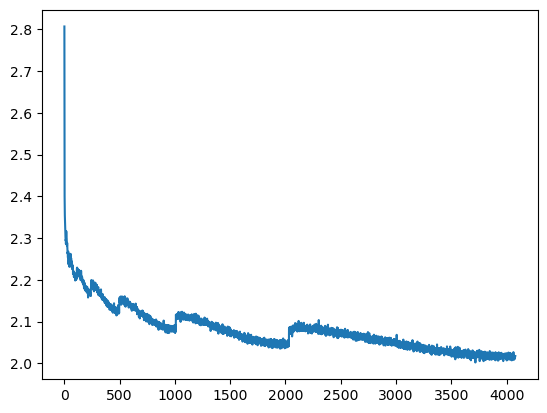

In [83]:
plt.plot(np.arange(len(Train)),Train)

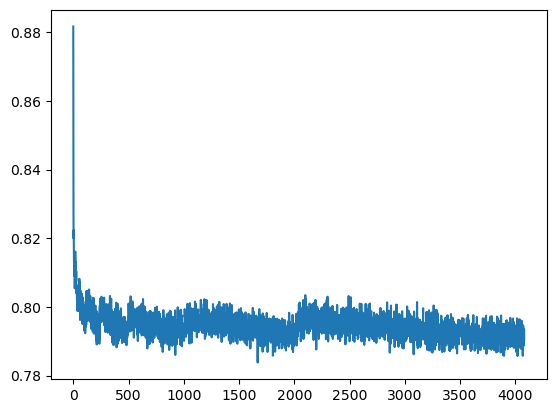

In [84]:
plt.plot(np.arange(len(Eval)),Eval)

In [85]:
fname = "models/stateATT_6L_fixed.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7226094603538513

EVALUATING ON TEST DATA : 
score_test = 0.8081712126731873

EVALUATING ON VAL DATA : 
score_val = 0.7929782271385193



In [86]:
fname = "models/stateATT_6L_fixed_best.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7360283136367798

EVALUATING ON TEST DATA : 
score_test = 0.8089258074760437

EVALUATING ON VAL DATA : 
score_val = 0.7931158542633057

